In [1]:
# lib version used for project. Uncomment and install if needed
# !pip install pandas==1.5.0
# !pip install numpy==1.23.3

In [2]:
# Core libs
import pandas as pd
import numpy as np

# Handling datetime objects
import datetime
# from datetime import datetime, timedelta

# Fancy print
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import itertools

# In pandas sometimes false-positive copy-warning occur. These might be noisy. 
# lets's turn them off for school project
# I will also turn off future warnings, not needed fo school project
import warnings
# from pandas.errors import SettingWithCopyWarning

# Clustering
from sklearn.cluster import KMeans

warnings.simplefilter(action='ignore', category=FutureWarning)
# warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

I. Reading and understanding the data

Lets read the data and get general insights regarding data and DataFrame. At this stage I will

    1. Read data as pandas DataFrame object (hereinafter df)
    2. Get information of size and datatypes of df's series
    3. Investigate each series to understand the data

In [3]:
# 1. Reading and printing data
df = pd.read_csv('solar_221298.csv')
df.head(3)

timestamp  raw  temperature  modified1  modified2  modified3
0  1612224000000  0.0         -3.9        NaN        0.0        0.0
1  1612227600000  0.0         -3.5        NaN        0.0        0.0
2  1612231200000  0.0         -3.0        0.0        0.0        0.0

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17016 entries, 0 to 17015
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   timestamp    17016 non-null  int64  
 1   raw          17016 non-null  float64
 2   temperature  17016 non-null  float64
 3   modified1    15825 non-null  float64
 4   modified2    15641 non-null  float64
 5   modified3    15879 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 797.8 KB


I.

Our df contains 17016 rows and 6 columns. 
Memory occupation of df is strict and ~798 kB.
Df contains NaN values.
Series of df are of types: (timestamp) -> int64 and (rest of columns) -> float64

From Scope of Work (hereinafter SoW) I know that (quote):
    1. "Data set includes several modifications of an hourly electricity production data collected from a PV panel, located near Tallinn" 
    2. "The dataset is complemented by the temperature data"

From df analysis one can see that timestamps are present in the data. In SoW it is also said that data is hourly.
Thus, structure of the data is time-series.

In [5]:
df.describe()

timestamp            raw   temperature      modified1  \
count  1.701600e+04   17016.000000  17016.000000   15825.000000   
mean   1.643547e+12   36912.094888      6.609191   37039.325457   
std    1.797037e+10   66907.410347      9.292033   66991.067211   
min    1.612224e+12       0.000000    -24.500000       0.000000   
25%    1.628056e+12       0.000000     -0.200000       0.000000   
50%    1.643715e+12       0.000000      6.400000       0.000000   
75%    1.659028e+12   38258.015000     13.400000   38994.080000   
max    1.675292e+12  301630.010000     30.100000  301630.010000   

           modified2      modified3  
count   15641.000000   15879.000000  
mean    25506.277558   33958.829309  
std     50828.415005   65118.934709  
min         0.000000       0.000000  
25%         0.000000       0.000000  
50%         0.000000       0.000000  
75%     22090.490000   30661.975000  
max    266069.210000  301630.010000

I.

From description of series some conclusions can also be derived:
    1. timestamps:
        a. All the values are present, e.g. count = 17016
        b. It is given in unix-time format
        c. It is given up to millisecond, e.g. 1.6e+12, in seconds the order would be e.g. 1.6e+9
        d. As mean and 0.5 quantile do not match, we can suggest that time-step is not distinct within time-series
    2. raw:
        a. All the values are present, e.g. count = 17016
        b. SoW defines that data is a production of PV panels located near Tallinn. Max value equals 301630.01.
           Looking at that number and knowing that PV is allocated near Tallinn I conclude that unit of measurement is
           Watt*hour or Wh or 301.630 kWh. 
           And that makes sence, as there are no large PV parks (10 MW+) installed in Estonia today
        c. 0.5 quantile equals 0, meaning that 0's occure in at least in 50% of records
    3. temperature:
        a. All the values are present, e.g. count = 17016
        b. min value = -24.5 and max value = 30.1 and region is Estonia, 
           thus I can colnclude that unit of measurement is Celsius C-deg
    4. modified1, modified2, modified3
        a. Not all the values are present, each of the columns include missing data NaN's
        b. From SoW and description it can be concluded that columns are modified based on raw column

II Converting data and data-types, sorting, duplicates in timestamps

As in general it is more convenient to work with smaller numbers, some modifications shall be done

    1. Data is hourly, thus milliseconds will be deleted from timestamp data
        a. After deletin of miliseconds, data will fit int32 and uint32 instead of int64 and will save memory
    2. raw, modified1, modified2 and modified3 will be converted from Wh to kWh
    3. temperature will keep as is, will not start to convert to Kelvin at this stage at least
    4. will introduce timestamp in a form of datetime, as it is more convenient for human to understand data as datetime
    
As format of the data is time-series, data shall be sorted correctly. 
This is critical, because in time-series the most important feature/attribute to predict next datapoint is often it's previous datapoint.

In [6]:
df = df.sort_values(by=['timestamp'])  # lets sort the data first
df = df.reset_index(drop=True)  # and reset index (it is usefull in case if rows were shifted)
df.head(3)

timestamp  raw  temperature  modified1  modified2  modified3
0  1612224000000  0.0         -3.9        NaN        0.0        0.0
1  1612227600000  0.0         -3.5        NaN        0.0        0.0
2  1612231200000  0.0         -3.0        0.0        0.0        0.0

In [7]:
# let's now work with data simplification and type casting
df['timestamp'] = (df['timestamp'] / 1000).astype('uint32')  # drop miliseconds
df, df.info()  # now we occupy just 731/798*100 = 91.6% of initial memory, quite nice improvement with just a one-liner

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17016 entries, 0 to 17015
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   timestamp    17016 non-null  uint32 
 1   raw          17016 non-null  float64
 2   temperature  17016 non-null  float64
 3   modified1    15825 non-null  float64
 4   modified2    15641 non-null  float64
 5   modified3    15879 non-null  float64
dtypes: float64(5), uint32(1)
memory usage: 731.3 KB


(        timestamp  raw  temperature  modified1  modified2  modified3
 0      1612224000  0.0         -3.9        NaN        0.0        0.0
 1      1612227600  0.0         -3.5        NaN        0.0        0.0
 2      1612231200  0.0         -3.0        0.0        0.0        0.0
 3      1612234800  0.0         -2.6        0.0        0.0        0.0
 4      1612238400  0.0         -2.4        0.0        0.0        0.0
 ...           ...  ...          ...        ...        ...        ...
 17011  1675278000  0.0          0.0        NaN        0.0        0.0
 17012  1675281600  0.0          0.1        0.0        0.0        0.0
 17013  1675285200  0.0          0.1        0.0        0.0        0.0
 17014  1675288800  0.0          0.2        0.0        0.0        0.0
 17015  1675292400  0.0          0.2        0.0        0.0        0.0
 
 [17016 rows x 6 columns],
 None)

In [8]:
# Check time step of provided data
(df[['timestamp']] - df[['timestamp']].shift(1))['timestamp'].value_counts()

3600.0      17004
90000.0        10
954000.0        1
Name: timestamp, dtype: int64

As mentioned above, time-step is not distinct. Missing data perdios are present in data.
10 smaller periods (missing records for one day)
1 larger period (missing records for 11 days)

Lets check frequency of daily missing records

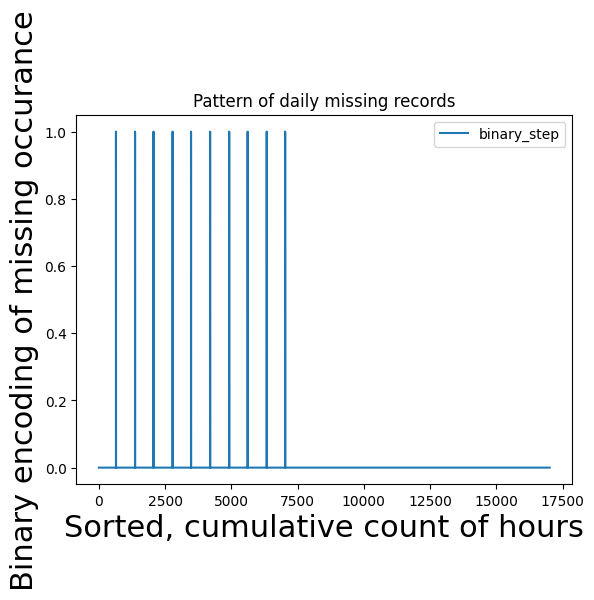

In [9]:
df['timestamp_shifted'] = (df['timestamp'] - df['timestamp'].shift(1))
df['cumcount'] = df.index - 1

df.loc[(df['timestamp_shifted'] >= 5000) & (df['timestamp_shifted'] < 100000), 'binary_step'] = 1

df['binary_step'] = df['binary_step'].fillna(0)
df[1:].plot(x='cumcount',y='binary_step')

plt.title("Pattern of daily missing records")
plt.xlabel("Sorted, cumulative count of hours", fontsize=22)
plt.ylabel("Binary encoding of missing occurance", fontsize=22)
plt.show()

From chart one can see that there is defnatelly some pattern present of how records are missing.
Daily missing records occured in the beginning of the data and with same or very similar fcrequency.

In [10]:
# Droping previosly enginered features at the moment
df = df.drop(columns=['timestamp_shifted','cumcount','binary_step'])
df.head(3)

timestamp  raw  temperature  modified1  modified2  modified3
0  1612224000  0.0         -3.9        NaN        0.0        0.0
1  1612227600  0.0         -3.5        NaN        0.0        0.0
2  1612231200  0.0         -3.0        0.0        0.0        0.0

In [11]:
# Converting features further.
# Simplifing data for columns ['raw', 'modified1', 'modified2', 'modified3']

feature_list = ['raw', 'modified1', 'modified2', 'modified3']

for feature in feature_list:
    df[feature] = df[feature] / 1000  # going to kWh scale

df.describe()

timestamp           raw   temperature     modified1     modified2  \
count  1.701600e+04  17016.000000  17016.000000  15825.000000  15641.000000   
mean   1.643547e+09     36.912095      6.609191     37.039325     25.506278   
std    1.797037e+07     66.907410      9.292033     66.991067     50.828415   
min    1.612224e+09      0.000000    -24.500000      0.000000      0.000000   
25%    1.628056e+09      0.000000     -0.200000      0.000000      0.000000   
50%    1.643715e+09      0.000000      6.400000      0.000000      0.000000   
75%    1.659028e+09     38.258015     13.400000     38.994080     22.090490   
max    1.675292e+09    301.630010     30.100000    301.630010    266.069210   

          modified3  
count  15879.000000  
mean      33.958829  
std       65.118935  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%       30.661975  
max      301.630010

In [12]:
# lets add datetime format series to existing dataframe to make it easier to undrestand what is going on for humans
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
df.head(3)  # now take couple of instances and check if convertion was succesfull using epoch converters found in web 

timestamp  raw  temperature  modified1  modified2  modified3  \
0  1612224000  0.0         -3.9        NaN        0.0        0.0   
1  1612227600  0.0         -3.5        NaN        0.0        0.0   
2  1612231200  0.0         -3.0        0.0        0.0        0.0   

             datetime  
0 2021-02-02 00:00:00  
1 2021-02-02 01:00:00  
2 2021-02-02 02:00:00

In [13]:
# Now lets check if there are duplicates in datetime and/or timestapms (maybe leap year inside the data)
df['datetime'].value_counts().nunique(), df['timestamp'].value_counts().nunique()  # datetime and timestamp are unique values, no leap year present in the data

(1, 1)

In [14]:
# Lets rearange columns to make it bit more convinient
df = df[['timestamp','datetime','raw','modified1','modified2','modified3','temperature']]
df.head(3)

timestamp            datetime  raw  modified1  modified2  modified3  \
0  1612224000 2021-02-02 00:00:00  0.0        NaN        0.0        0.0   
1  1612227600 2021-02-02 01:00:00  0.0        NaN        0.0        0.0   
2  1612231200 2021-02-02 02:00:00  0.0        0.0        0.0        0.0   

   temperature  
0         -3.9  
1         -3.5  
2         -3.0

III Investigate missing data NaN's

    1. Columns modified1, modified2 and modified3 include NaN values
    
From SoW it is needed to identify the possible types of missing data. 
It is also required to use at least three different methods to handle the missing data for variable modified1.
These three different methods shall be based on deletion, univariate, and multivariate imputation techniques.

In [15]:
# Lets start with investigating NaN's
nrows = df.shape[0]

# Printing column-based NaN data
pd.DataFrame({'column_name':df.columns,
              'missing_data_count':df.isnull().sum().to_list(),
              'missing_data_%':round(df.isnull().sum() / nrows * 100, 2).to_list()})

column_name  missing_data_count  missing_data_%
0    timestamp                   0            0.00
1     datetime                   0            0.00
2          raw                   0            0.00
3    modified1                1191            7.00
4    modified2                1375            8.08
5    modified3                1137            6.68
6  temperature                   0            0.00

As mentioned above, only columns modified1, modified2 and modified3 include NaN values

Lets investigate NaN's further. From NaN occurance patterns let's try to understand the nature of NaN's, if data is missing at random, completely at random or not at random.
During practise 'missingno' package was used to get insights of missing values.
However, 'missingno' have some security and maintenability concerns (Snyk project: https://snyk.io/advisor/python/missingno)

Lets follow 'security first' principles and implement some similar visuals and 'pattern-insights'

We will not get that fancy graphs as with 'missingno', but still we will be able to read some insights

In [16]:
# Lets declare a function which will pretty-print missing values for us
# White strips will signalise missing values and black present data

def fancy_print_missingno(df:pd.DataFrame,col:str) -> None:
    
    '''
    Method to plot missing values of pandas df series
    '''
    
    data = df[col].apply(lambda x: 1 if pd.notna(x) else 0).to_numpy()  # this will convert notnan's to 1 and nan's to 0, binary vector basically
    data = np.array([data])  # need 2D for imshow() function

    plt.figure(figsize=(40, 1))  # to make a print in a form of flat bar
    
    cmap = mcolors.ListedColormap(['white', 'black'])
    
    plt.imshow(data, cmap=cmap, aspect='auto', interpolation='nearest')
    
    plt.xticks([])
    plt.yticks([])
    plt.show()
    

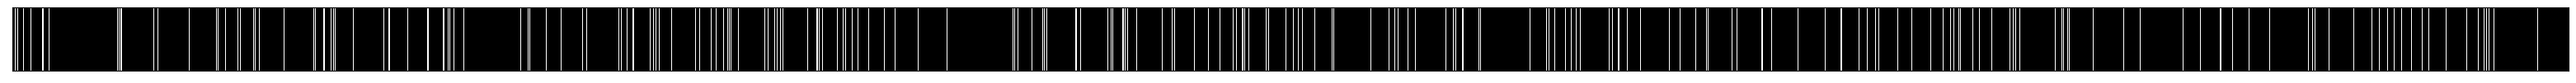

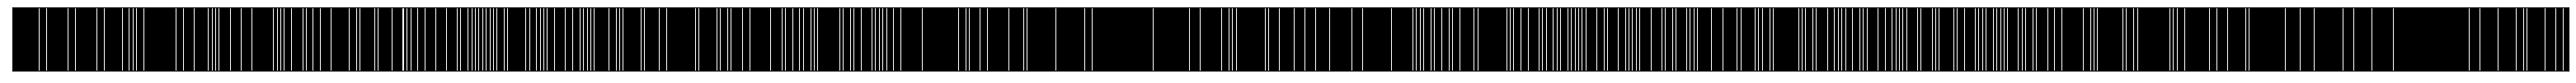

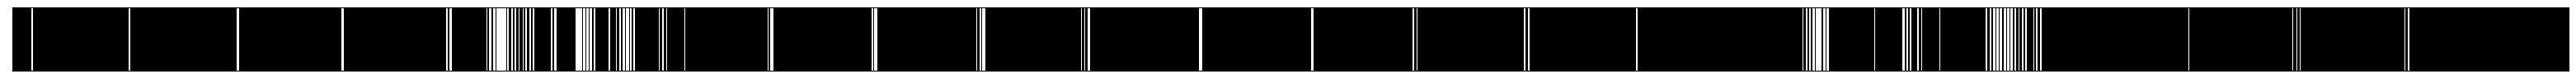

(None, None, None)

In [17]:
fancy_print_missingno(df=df,col='modified1'), fancy_print_missingno(df=df,col='modified2'), fancy_print_missingno(df=df,col='modified3')

So, we can clearly see that nature of missing data in modified3 is something completelly different comparing to modified1 and modified2.

Lets explore a bit further. Lets check if there are some correlations between missing data and another features.
We already have temperature feature, but lets also add some additional time-wise features and check if some correlations with these features will occur as well.
I will add:
    1. Day of the week (0-6. 0-Monday, 6-Sunday)
    2. Month (0-11)
    3. Hour (0-23)

In [18]:
df['day_of_week'] = df['datetime'].dt.weekday
df['month'] = df['datetime'].dt.month
df['hour'] = df['datetime'].dt.hour

# And because I want to represent day of week, month and hour as nominal features for correlation nalysis, I will one-hot-encode them
cols_to_encode = ['day_of_week','month','hour']
df_cols_to_encode = df[cols_to_encode]

df = pd.get_dummies(df, columns=cols_to_encode, drop_first=False)
df = pd.concat([df,df_cols_to_encode],axis=1)

df.head(3)

timestamp            datetime  raw  modified1  modified2  modified3  \
0  1612224000 2021-02-02 00:00:00  0.0        NaN        0.0        0.0   
1  1612227600 2021-02-02 01:00:00  0.0        NaN        0.0        0.0   
2  1612231200 2021-02-02 02:00:00  0.0        0.0        0.0        0.0   

   temperature  day_of_week_0  day_of_week_1  day_of_week_2  ...  hour_17  \
0         -3.9              0              1              0  ...        0   
1         -3.5              0              1              0  ...        0   
2         -3.0              0              1              0  ...        0   

   hour_18  hour_19  hour_20  hour_21  hour_22  hour_23  day_of_week  month  \
0        0        0        0        0        0        0            1      2   
1        0        0        0        0        0        0            1      2   
2        0        0        0        0        0        0            1      2   

   hour  
0     0  
1     1  
2     2  

[3 rows x 53 columns]

In [19]:
# And I will represent modified1, modified2 and modified3 as binary vectors to catch correlations between presence 0/1 rather magnitude value of these columns
for column in ['modified1', 'modified2', 'modified3']:
    df[column + '_binary'] = df[column].apply(lambda x: 1 if pd.notna(x) else 0)
df.head(3)

timestamp            datetime  raw  modified1  modified2  modified3  \
0  1612224000 2021-02-02 00:00:00  0.0        NaN        0.0        0.0   
1  1612227600 2021-02-02 01:00:00  0.0        NaN        0.0        0.0   
2  1612231200 2021-02-02 02:00:00  0.0        0.0        0.0        0.0   

   temperature  day_of_week_0  day_of_week_1  day_of_week_2  ...  hour_20  \
0         -3.9              0              1              0  ...        0   
1         -3.5              0              1              0  ...        0   
2         -3.0              0              1              0  ...        0   

   hour_21  hour_22  hour_23  day_of_week  month  hour  modified1_binary  \
0        0        0        0            1      2     0                 0   
1        0        0        0            1      2     1                 0   
2        0        0        0            1      2     2                 1   

   modified2_binary  modified3_binary  
0                 1                 1  
1                 1                 1  
2                 1                 1  

[3 rows x 56 columns]

In [20]:
# Finally, lets calculate correlations
df_corr = pd.DataFrame()

for column in ['modified1_binary', 'modified2_binary', 'modified3_binary']:
    df_corr = pd.concat([df_corr,df.corr()[column].reset_index()],axis=1,)

df_corr = df_corr.loc[:, ~df_corr.columns.duplicated()]
df_corr = df_corr.loc[~df_corr['index'].isin(['timestamp','raw','modified1','modified2','modified3',
                                             'modified1_binary','modified2_binary','modified3_binary']), :]
df_corr.head(5)

index  modified1_binary  modified2_binary  modified3_binary
5    temperature          0.009238         -0.116066         -0.501724
6  day_of_week_0         -0.005967         -0.009952         -0.001781
7  day_of_week_1         -0.014871          0.005415         -0.014368
8  day_of_week_2         -0.004176          0.007943         -0.000020
9  day_of_week_3          0.025798         -0.001279          0.002276

In [21]:
# And analyse correlation for each feature. 
# Feature modified1
modified1_corrs = df_corr[['index','modified1_binary']].sort_values(by=['modified1_binary'])
modified1_corrs['modified1_binary_abs'] = modified1_corrs['modified1_binary'].abs()
modified1_corrs.sort_values(by='modified1_binary_abs',ascending=False).head(10)

index  modified1_binary  modified1_binary_abs
9   day_of_week_3          0.025798              0.025798
31         hour_6          0.016858              0.016858
32         hour_7          0.016858              0.016858
48        hour_23          0.015706              0.015706
7   day_of_week_1         -0.014871              0.014871
41        hour_16         -0.013112              0.013112
21        month_9         -0.012417              0.012417
30         hour_5         -0.011959              0.011959
37        hour_12         -0.011959              0.011959
43        hour_18         -0.010807              0.010807

Basically there is no any significant correlations between modified1 and another features.

As missing data of modified1 does not correlate with any other feature, I conclude that data of modified1 is missing completely at random (MCAR)

In [ ]:
# Feature modified2
modified2_corrs = df_corr[['index','modified2_binary']].sort_values(by=['modified2_binary'])
modified2_corrs['modified2_binary_abs'] = modified2_corrs['modified2_binary'].abs()
modified2_corrs.sort_values(by='modified2_binary_abs',ascending=False).head(10)

index  modified2_binary  modified2_binary_abs
35      hour_10         -0.270541              0.270541
36      hour_11         -0.238167              0.238167
34       hour_9         -0.232772              0.232772
37      hour_12         -0.144285              0.144285
33       hour_8         -0.135652              0.135652
5   temperature         -0.116066              0.116066
51         hour          0.066305              0.066305
28       hour_3          0.061824              0.061824
29       hour_4          0.061824              0.061824
27       hour_2          0.061824              0.061824

There is a correlation between modified2 missing data and at least these features:
    1. hour_10
    2. hour_11
    3. hour_9
    4. hour_12
    5. hour_8
    6. temperature

It is interesting that together with part of day, also temprerature is in correlation with modified2 missing data.
Lets investigate this hourly and thermo dependecies a little bit futher...

In [23]:
df.groupby('hour')['modified2_binary'].sum()

hour
0     709
1     709
2     709
3     709
4     709
5     709
6     705
7     627
8     526
9     436
10    401
11    431
12    518
13    660
14    702
15    709
16    709
17    709
18    709
19    709
20    709
21    709
22    709
23    709
Name: modified2_binary, dtype: int64

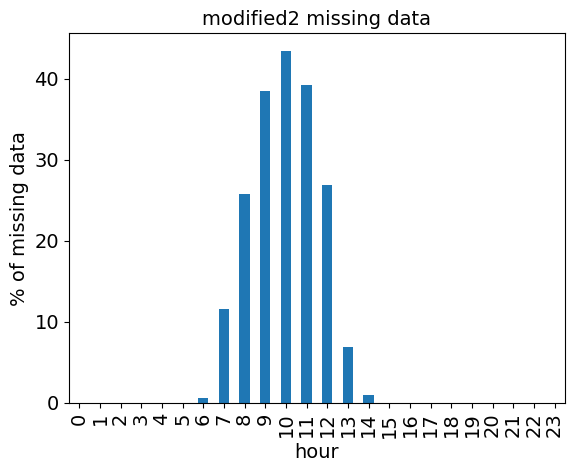

In [24]:
(100 - df.groupby('hour')['modified2_binary'].sum()/709*100).plot.bar(xlabel='hour', 
                                                                      ylabel='% of missing data', 
                                                                      title='modified2 missing data')

plt.xlabel("hour", fontsize=14)
plt.ylabel("% of missing data", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('modified2 missing data',fontsize=14)
plt.show()

Now it is clear, that data is missing for some specific hours (from 7+1 to 14+1)
Lets check mean hourly production of modified2

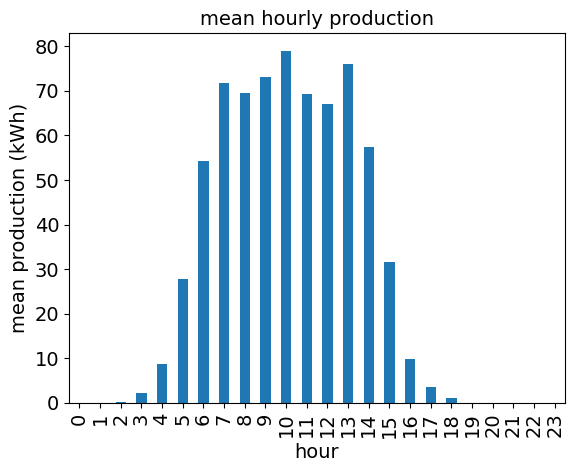

In [25]:
df.groupby('hour')['modified2'].mean().plot.bar(xlabel='hour', 
                                                ylabel='mean production (kWh)', 
                                                title='mean hourly production')

plt.xlabel("hour", fontsize=14)
plt.ylabel("mean production (kWh)", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('mean hourly production',fontsize=14)
plt.show()

So it is clear that data is missing during periods or largest production.
A hypothesis might be that data is missing due to errors in measurements because of high intention of sun insolation.
Such missing data mechanism could be classified as MAR

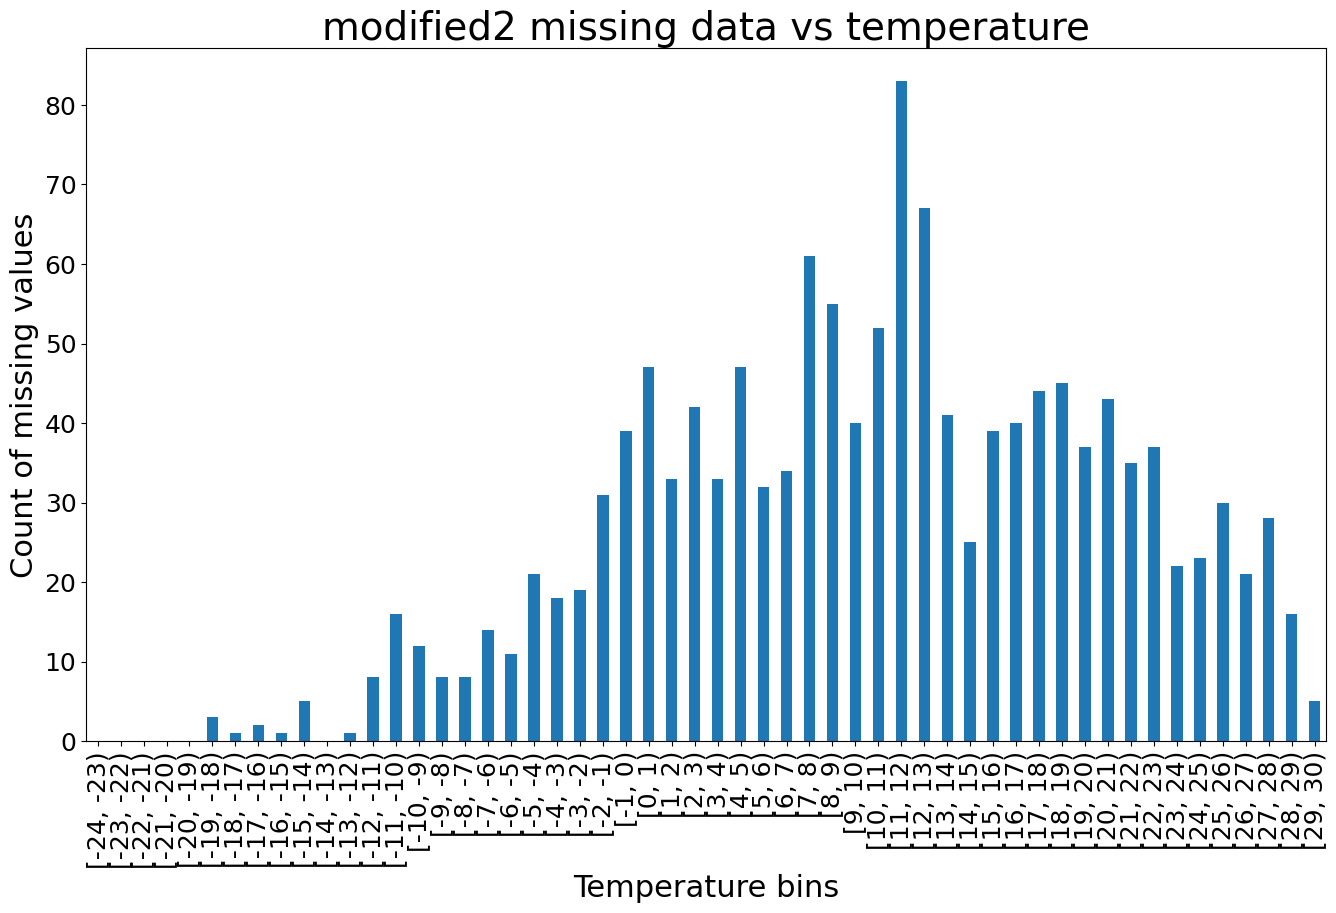

In [26]:
# Lets also check correlations between missing values of modified2 and temperature
degree_step = 1
bins = range(int(df['temperature'].min()), int(df['temperature'].max()) + degree_step, degree_step)
df['temp_bin'] = pd.cut(df['temperature'], bins=bins, right=False)
df.groupby('temp_bin')['modified2'].apply(lambda x: x.isna().sum()).plot.bar(figsize=(16,9))

plt.xlabel("Temperature bins", fontsize=22)
plt.ylabel("Count of missing values", fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('modified2 missing data vs temperature',fontsize=28)
plt.show()

From temperature it is not 100% sure what could be the reason of modified2 missing values.
There is relationship between temperature and missing values, for larger temperatures, missing values occur more.
So we will stick to the hyposesis mentioned above regarding mechanism of missing values of modified2

In [27]:
# Feature modified3
modified3_corrs = df_corr[['index','modified3_binary']].sort_values(by=['modified3_binary'])
modified3_corrs['modified3_binary_abs'] = modified3_corrs['modified3_binary'].abs()
modified3_corrs.sort_values(by='modified3_binary_abs',ascending=False).head(10)

index  modified3_binary  modified3_binary_abs
5   temperature         -0.501724              0.501724
18      month_6         -0.197153              0.197153
19      month_7         -0.145342              0.145342
20      month_8         -0.109253              0.109253
21      month_9          0.059318              0.059318
15      month_3          0.058601              0.058601
38      hour_13         -0.057268              0.057268
37      hour_12         -0.057268              0.057268
13      month_1          0.057191              0.057191
27       hour_2          0.052263              0.052263

We see that correlation between missing values and temeprature is extremly high.
Lets break down tempeerature to bins and check how much data is missing bins-vise

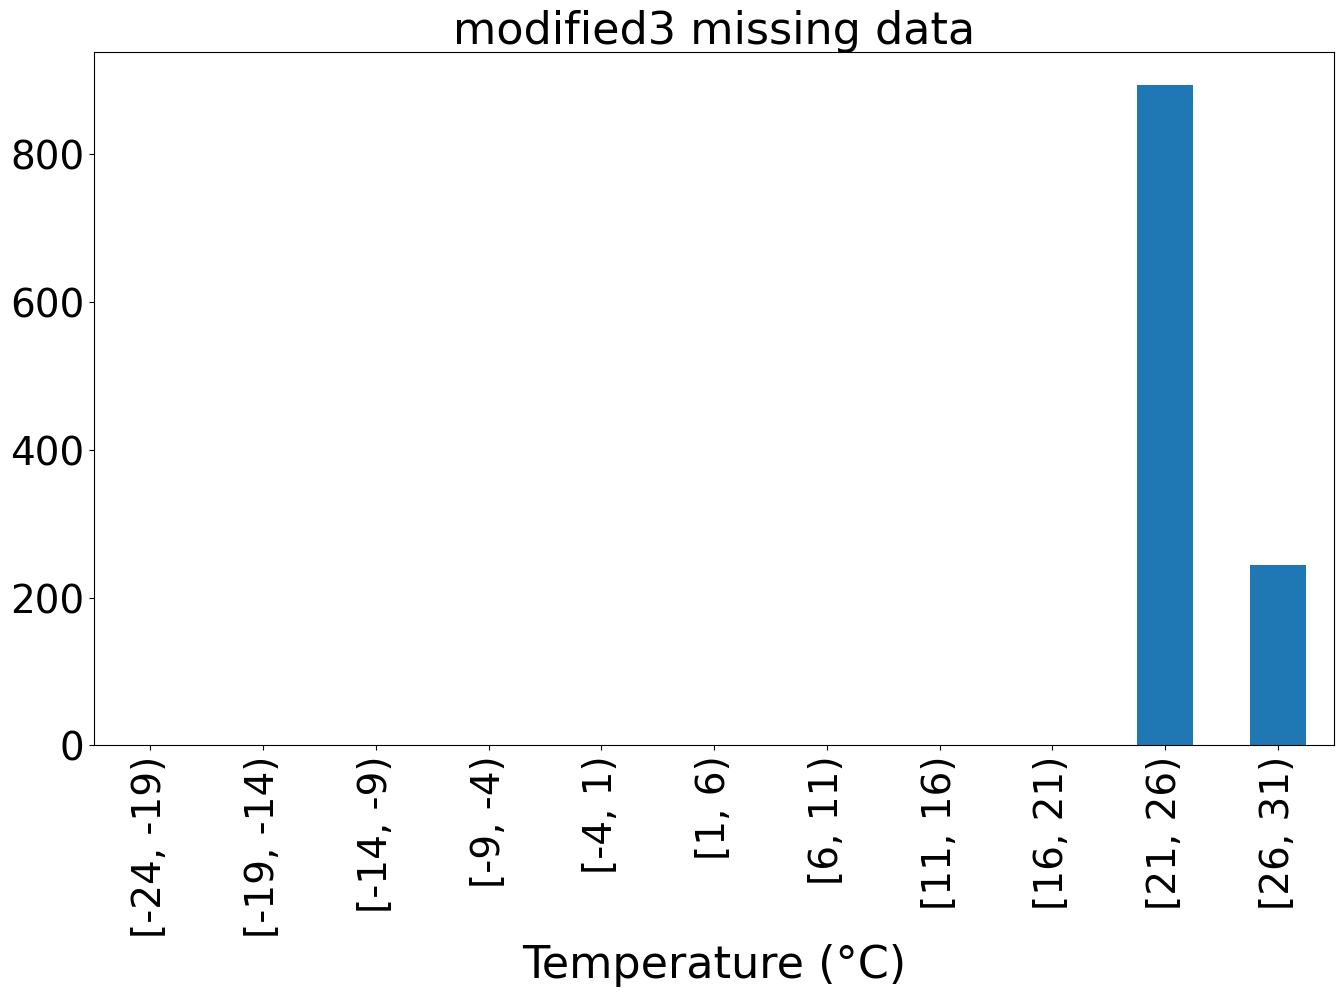

In [28]:
degree_step = 5
bins = range(int(df['temperature'].min()), int(df['temperature'].max()) + degree_step, degree_step)
df['temp_bin'] = pd.cut(df['temperature'], bins=bins, right=False)
df.groupby('temp_bin')['modified3'].apply(lambda x: x.isna().sum()).plot.bar(figsize=(16,9))
plt.xlabel("Temperature (°C)", fontsize=32)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.title('modified3 missing data',fontsize=32)
plt.show()

So data is missing starting from some temperature. Lets check if all the data is missing starting from some temperature threshold.

In [29]:
df[df['modified3'].notna()]['temperature'].max(), df['temperature'].max()

(21.0, 30.1)

Indeed, all the values starting from temperature 21 C is missing.
It can be suggested to be MNAR due to the hypothesis that for very high temperatures, it was so much sun insulation and PV power, that high generation (with high insolation) might have caused the missing data. So, the data point is responsible on its own for missing values.

After analysis of missing data, let's drop unnecessary columns and go back to more compact DataFrame
As from now on I don't have to work with 'modified2' and 'modified3' will be dropped

In [30]:
df = df[['timestamp','datetime','raw','modified1','temperature']]
df

timestamp            datetime  raw  modified1  temperature
0      1612224000 2021-02-02 00:00:00  0.0        NaN         -3.9
1      1612227600 2021-02-02 01:00:00  0.0        NaN         -3.5
2      1612231200 2021-02-02 02:00:00  0.0        0.0         -3.0
3      1612234800 2021-02-02 03:00:00  0.0        0.0         -2.6
4      1612238400 2021-02-02 04:00:00  0.0        0.0         -2.4
...           ...                 ...  ...        ...          ...
17011  1675278000 2023-02-01 19:00:00  0.0        NaN          0.0
17012  1675281600 2023-02-01 20:00:00  0.0        0.0          0.1
17013  1675285200 2023-02-01 21:00:00  0.0        0.0          0.1
17014  1675288800 2023-02-01 22:00:00  0.0        0.0          0.2
17015  1675292400 2023-02-01 23:00:00  0.0        0.0          0.2

[17016 rows x 5 columns]

III Handling missing data
    a. on deletion
    b. univariante imputation
    c. multivariate imputation

In [31]:
# a. Handling missing data on deletion
df_clean_on_deletion = df[df['modified1'].notna()].reset_index(drop=True)
df_clean_on_deletion

timestamp            datetime  raw  modified1  temperature
0      1612231200 2021-02-02 02:00:00  0.0        0.0         -3.0
1      1612234800 2021-02-02 03:00:00  0.0        0.0         -2.6
2      1612238400 2021-02-02 04:00:00  0.0        0.0         -2.4
3      1612242000 2021-02-02 05:00:00  0.0        0.0         -2.1
4      1612245600 2021-02-02 06:00:00  0.0        0.0         -2.0
...           ...                 ...  ...        ...          ...
15820  1675274400 2023-02-01 18:00:00  0.0        0.0         -0.3
15821  1675281600 2023-02-01 20:00:00  0.0        0.0          0.1
15822  1675285200 2023-02-01 21:00:00  0.0        0.0          0.1
15823  1675288800 2023-02-01 22:00:00  0.0        0.0          0.2
15824  1675292400 2023-02-01 23:00:00  0.0        0.0          0.2

[15825 rows x 5 columns]

First method is very simple and straight-forward. We just drop rows with missing values
As a result, sufficient amount of data is lost

In [32]:
# b. Handling missing data on univariante imputation
# First of all I will introduce additional columns: date, hour and step

In [33]:
df['date'] = df['datetime'].dt.date
df['hour'] = df['datetime'].dt.hour
df['step'] = df.groupby('date').cumcount() + 1
df.head(3)

timestamp            datetime  raw  modified1  temperature        date  \
0  1612224000 2021-02-02 00:00:00  0.0        NaN         -3.9  2021-02-02   
1  1612227600 2021-02-02 01:00:00  0.0        NaN         -3.5  2021-02-02   
2  1612231200 2021-02-02 02:00:00  0.0        0.0         -3.0  2021-02-02   

   hour  step  
0     0     1  
1     1     2  
2     2     3

Now using knowledge above, distribution of modified2 was bell-shaped, I suggest that distribution of modified1 is also bell-shape. Let's check.

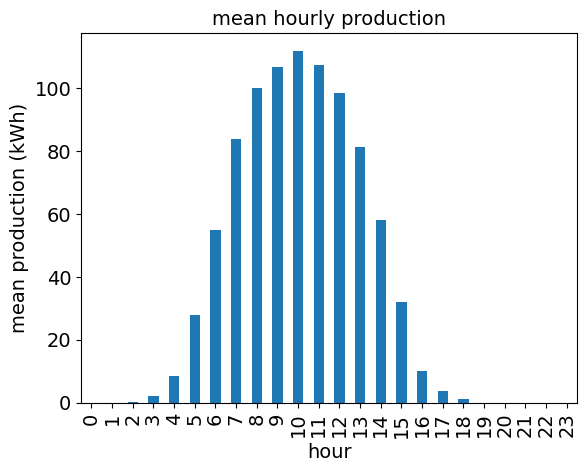

In [34]:
df.groupby('hour')['modified1'].mean().plot.bar(xlabel='hour', 
                                                ylabel='mean production (kWh)', 
                                                title='mean hourly production')

plt.xlabel("hour", fontsize=14)
plt.ylabel("mean production (kWh)", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('mean hourly production',fontsize=14)
plt.show()

And that is indeed true. The best suitable and simple model to fit such pattern would be 4,6,8,etc. order polynominal
Let's make poly-model and try to fit on our mean hourly data

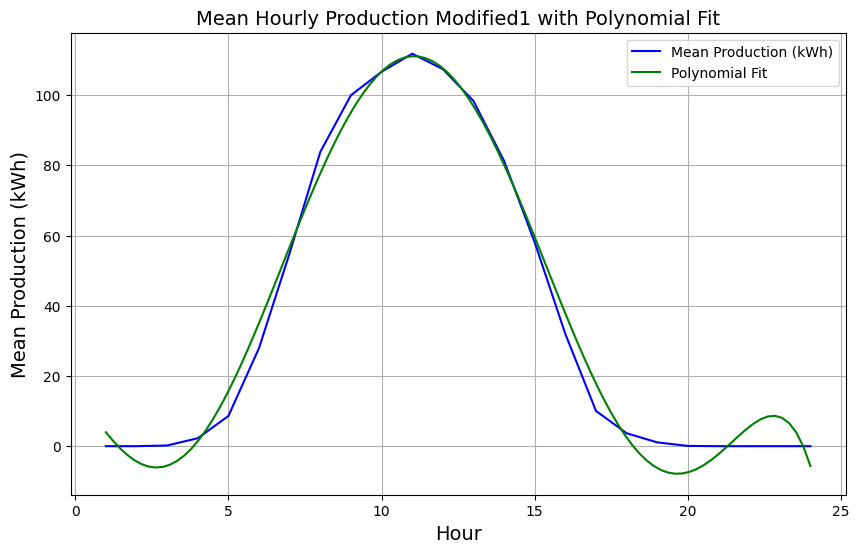

In [35]:
mean_values = df.groupby('step')['modified1'].mean()
poly_strength = 6

coefficients = np.polyfit(mean_values.index, mean_values.values, poly_strength)
polynomial = np.poly1d(coefficients)

x_values = np.linspace(mean_values.index.min(), mean_values.index.max(), 100)
y_values = polynomial(x_values)


plt.figure(figsize=(10, 6))
mean_values.plot(label='Mean Production (kWh)', color='blue')
plt.plot(x_values, y_values, label='Polynomial Fit', color='green')

# Adding labels and title
plt.xlabel('Hour', fontsize=14)
plt.ylabel('Mean Production (kWh)', fontsize=14)
plt.title('Mean Hourly Production Modified1 with Polynomial Fit', fontsize=14)
plt.legend()
plt.grid()

# Show the plot
plt.show()

It fits quite good. Largest the order of polynom, the better the fit would be.
However risks of overfitting will also be higher.
We lso concluded that mechanism of missing values for modified1 was MCAR.
So, our poly-model could be a good choice.

In [36]:
# Spaghetti-Code Warning
# Achtung! Spaghetti-Code used for inputations below...

In [37]:
# Declaring spaghetti columns
df['to_fill'] = df['modified1']
df['modified1_single_inputation'] = df['modified1']
df['modified1_multi_inputation'] = df['modified1']
df.head(3)

timestamp            datetime  raw  modified1  temperature        date  \
0  1612224000 2021-02-02 00:00:00  0.0        NaN         -3.9  2021-02-02   
1  1612227600 2021-02-02 01:00:00  0.0        NaN         -3.5  2021-02-02   
2  1612231200 2021-02-02 02:00:00  0.0        0.0         -3.0  2021-02-02   

   hour  step  to_fill  modified1_single_inputation  \
0     0     1      NaN                          NaN   
1     1     2      NaN                          NaN   
2     2     3      0.0                          0.0   

   modified1_multi_inputation  
0                         NaN  
1                         NaN  
2                         0.0

In [38]:
# This chunk is used to calculate single shot imputation

poly_strength = 6


def fit_polynomial(group):
        
    x = group[~group['modified1'].isna()]['step'].to_list()
    y = group[~group['modified1'].isna()]['modified1'].to_list()
        
    coefficients = np.polyfit(x, y, poly_strength)
    polynomial = np.poly1d(coefficients)

    missing_hours = group[group['to_fill'].isna()]['step']
        
    group.loc[group['to_fill'].isna(), 'modified1_single_inputation'] = polynomial(missing_hours.to_list())
    
    return group

df = df.groupby('date').apply(fit_polynomial)
df.head(3)

timestamp            datetime  raw  modified1  temperature        date  \
0  1612224000 2021-02-02 00:00:00  0.0        NaN         -3.9  2021-02-02   
1  1612227600 2021-02-02 01:00:00  0.0        NaN         -3.5  2021-02-02   
2  1612231200 2021-02-02 02:00:00  0.0        0.0         -3.0  2021-02-02   

   hour  step  to_fill  modified1_single_inputation  \
0     0     1      NaN                          0.0   
1     1     2      NaN                          0.0   
2     2     3      0.0                          0.0   

   modified1_multi_inputation  
0                         NaN  
1                         NaN  
2                         0.0

In [39]:
# This chunk is for multivariate imputation
# For multivariate, I am using neighbours of days and calculation hourly mean values 

df['modified1_3day_mean'] = df.groupby('step')['to_fill'].rolling(window=3, min_periods=1,center=True).mean().reset_index(level=0, drop=True)

poly_strength = 6

def fit_polynomial(group):
    
    x = group[~group['modified1_3day_mean'].isna()]['step'].to_list()
    y = group[~group['modified1_3day_mean'].isna()]['modified1_3day_mean'].to_list()
    
    coefficients = np.polyfit(x, y, poly_strength)
    polynomial = np.poly1d(coefficients)

    missing_hours = group[group['to_fill'].isna()]['step']
    group.loc[group['to_fill'].isna(), 'modified1_multi_inputation'] = polynomial(missing_hours)

    return group

df = df.groupby('date').apply(fit_polynomial)
df = df.drop(columns=['modified1_3day_mean','to_fill'])  # droping what is not needed any more

df.head(3)

timestamp            datetime  raw  modified1  temperature        date  \
0  1612224000 2021-02-02 00:00:00  0.0        NaN         -3.9  2021-02-02   
1  1612227600 2021-02-02 01:00:00  0.0        NaN         -3.5  2021-02-02   
2  1612231200 2021-02-02 02:00:00  0.0        0.0         -3.0  2021-02-02   

   hour  step  modified1_single_inputation  modified1_multi_inputation  
0     0     1                          0.0                3.616559e-16  
1     1     2                          0.0               -1.033773e-15  
2     2     3                          0.0                0.000000e+00

Now we have results of both uni- and multivariate imputations.
We also know from polynominal models that they will tend to predict some parts of data as negative values.
But from data analysis we also know that min values are 0 for modified1 (so it is putre production, PV was never in consumption mode)
And this gives us good background to go further with imputation models, we can 'shave' negative values (by replacing with zeros). 
So, let's do that

In [40]:
# Shaving zero's as we know that PV haven't been acting in consumer mode
df.loc[df['modified1_single_inputation'] < 0, 'modified1_single_inputation_shaved'] = 0
df.loc[df['modified1_multi_inputation'] < 0, 'modified1_multi_inputation_shaved'] = 0

df['modified1_single_inputation_shaved'] = df['modified1_single_inputation_shaved'].fillna(df['modified1_single_inputation'])
df['modified1_multi_inputation_shaved'] = df['modified1_multi_inputation_shaved'].fillna(df['modified1_multi_inputation'])

df.head(3)

timestamp            datetime  raw  modified1  temperature        date  \
0  1612224000 2021-02-02 00:00:00  0.0        NaN         -3.9  2021-02-02   
1  1612227600 2021-02-02 01:00:00  0.0        NaN         -3.5  2021-02-02   
2  1612231200 2021-02-02 02:00:00  0.0        0.0         -3.0  2021-02-02   

   hour  step  modified1_single_inputation  modified1_multi_inputation  \
0     0     1                          0.0                3.616559e-16   
1     1     2                          0.0               -1.033773e-15   
2     2     3                          0.0                0.000000e+00   

   modified1_single_inputation_shaved  modified1_multi_inputation_shaved  
0                                 0.0                       3.616559e-16  
1                                 0.0                       0.000000e+00  
2                                 0.0                       0.000000e+00

And now it's time to check performance metrics of our poly-fit

In [41]:
def nrows(df):
    
    return df.shape[0]

In [42]:
def delta(df,actual_col,predicted_col):
    
    return df[actual_col] - df[predicted_col]

In [43]:
def mae_errors(df,actual_col,predicted_col):
    
    return delta(df,actual_col,predicted_col).abs()

In [44]:
def mape_errors(df,actual_col,predicted_col):
    
    df_discarded = df[df[actual_col] != 0]  # discard predictions where actual data is 0, bacause MAPE will be inf in that case 
    
    return (delta(df_discarded,actual_col,predicted_col)/(df_discarded[actual_col])).abs()

In [45]:
def mse_errors(df,actual_col,predicted_col):
    
    return delta(df,actual_col,predicted_col) ** 2

In [46]:
def mae(df,actual_col,predicted_col):

    return mae_errors(df,actual_col,predicted_col).sum() / nrows(df)

In [47]:
def mape(df,actual_col,predicted_col):
    
    return mape_errors(df,actual_col,predicted_col).sum() / nrows(mape_errors(df,actual_col,predicted_col))

In [48]:
def mse(df,actual_col,predicted_col):
    
    return mse_errors(df,actual_col,predicted_col).sum() / nrows(df)

In [49]:
def se(errors):
    
    return errors.std() / np.sqrt(errors.shape[0])

In [50]:
# MAE
{
    'modified1_single_inputation':mae(df,'raw','modified1_single_inputation').round(3),
    'modified1_multi_inputation':mae(df,'raw','modified1_multi_inputation').round(3),
    'modified1_single_inputation_shaved':mae(df,'raw','modified1_single_inputation_shaved').round(3),
    'modified1_multi_inputation_shaved':mae(df,'raw','modified1_multi_inputation_shaved').round(3),
}

{'modified1_single_inputation': 1.195,
 'modified1_multi_inputation': 1.172,
 'modified1_single_inputation_shaved': 0.811,
 'modified1_multi_inputation_shaved': 1.044}

In [51]:
# MAE Standard Error
{
    'se_modified1_single_inputation':se(mae_errors(df,'raw','modified1_single_inputation')).round(3),
    'se_modified1_multi_inputation':se(mae_errors(df,'raw','modified1_multi_inputation')).round(3),
    'se_modified1_single_inputation_shaved':se(mae_errors(df,'raw','modified1_single_inputation_shaved')).round(3),
    'se_modified1_multi_inputation_shaved':se(mae_errors(df,'raw','modified1_multi_inputation_shaved')).round(3),
}

{'se_modified1_single_inputation': 0.067,
 'se_modified1_multi_inputation': 0.06,
 'se_modified1_single_inputation_shaved': 0.046,
 'se_modified1_multi_inputation_shaved': 0.059}

In [52]:
# quasi MAPE (zeros discarded)
{
    'modified1_single_inputation':mape(df,'raw','modified1_single_inputation').round(3),
    'modified1_multi_inputation':mape(df,'raw','modified1_multi_inputation').round(3),
    'modified1_single_inputation_shaved':mape(df,'raw','modified1_single_inputation_shaved').round(3),
    'modified1_multi_inputation_shaved':mape(df,'raw','modified1_multi_inputation_shaved').round(3),
}

{'modified1_single_inputation': 5.925,
 'modified1_multi_inputation': 3.265,
 'modified1_single_inputation_shaved': 2.458,
 'modified1_multi_inputation_shaved': 1.673}

In [53]:
# quasi MAPE (zeros discarded) Standard Error
{
    'modified1_single_inputation':se(mape_errors(df,'raw','modified1_single_inputation')).round(3),
    'modified1_multi_inputation':se(mape_errors(df,'raw','modified1_multi_inputation')).round(3),
    'modified1_single_inputation_shaved':se(mape_errors(df,'raw','modified1_single_inputation_shaved')).round(3),
    'modified1_multi_inputation_shaved':se(mape_errors(df,'raw','modified1_multi_inputation_shaved')).round(3),
}

{'modified1_single_inputation': 3.757,
 'modified1_multi_inputation': 1.906,
 'modified1_single_inputation_shaved': 1.642,
 'modified1_multi_inputation_shaved': 1.151}

In [54]:
# MSE
{
    'modified1_single_inputation':mse(df,'raw','modified1_single_inputation').round(3),
    'modified1_multi_inputation':mse(df,'raw','modified1_multi_inputation').round(3),
    'modified1_single_inputation_shaved':mse(df,'raw','modified1_single_inputation_shaved').round(3),
    'modified1_multi_inputation_shaved':mse(df,'raw','modified1_multi_inputation_shaved').round(3),
}

{'modified1_single_inputation': 78.312,
 'modified1_multi_inputation': 62.372,
 'modified1_single_inputation_shaved': 35.941,
 'modified1_multi_inputation_shaved': 60.612}

In [55]:
# MSE Standard Error
{
    'se_modified1_single_inputation':se(mse_errors(df,'raw','modified1_single_inputation')).round(3),
    'se_modified1_multi_inputation':se(mse_errors(df,'raw','modified1_multi_inputation')).round(3),
    'se_modified1_single_inputation_shaved':se(mse_errors(df,'raw','modified1_single_inputation_shaved')).round(3),
    'se_modified1_multi_inputation_shaved':se(mse_errors(df,'raw','modified1_multi_inputation_shaved')).round(3),
}

{'se_modified1_single_inputation': 16.504,
 'se_modified1_multi_inputation': 5.651,
 'se_modified1_single_inputation_shaved': 3.997,
 'se_modified1_multi_inputation_shaved': 5.646}

From performance metrics we can see that model performce quite well. 
Multivariate imputation (based on meaning day with it's neighbours) is more stable comparing to univariate imputation.
Shaving also made performance of the models better, which is not a surprise at all.

Large MSE suggest that for some cases models totally missed to predict values.
MAPE is calculated in terms of quasi-MAPE, meaning that if actual value was zero, I discarded it, otherwise I would have end-up with infinit MAPEs

Lets check some good and bad fits

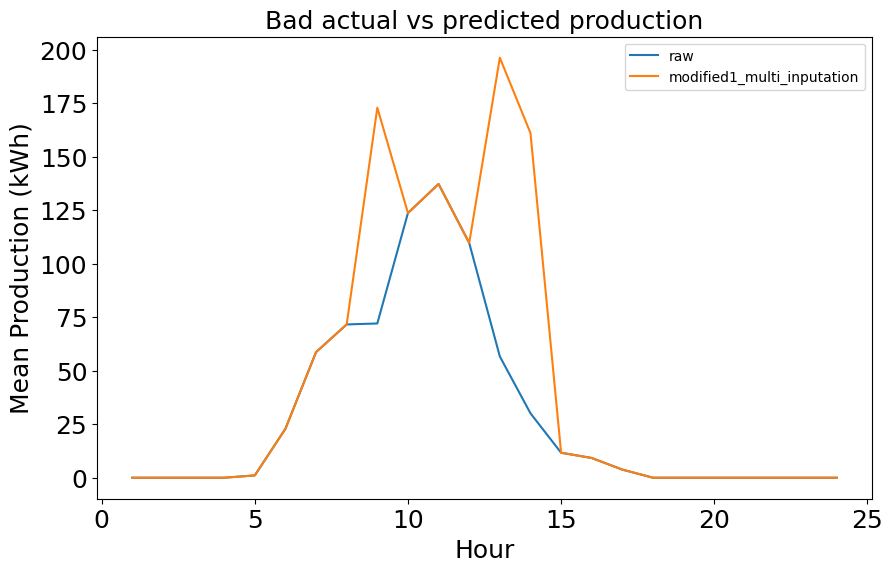

In [56]:
# lets check bad fit with large MSE errors
row_index = mse_errors(df,'raw','modified1_multi_inputation').sort_values().tail(5).index[0]
anomaly_date = anomaly_date = df[df.index == row_index]['date'].to_frame().reset_index(drop=True).loc[0,'date']

df[df['date'] == anomaly_date].plot('step',['raw','modified1_multi_inputation'],figsize=(10,6))

plt.xlabel('Hour',fontsize=18)
plt.ylabel('Mean Production (kWh)',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Bad actual vs predicted production',fontsize=18)
plt.legend(loc='upper right')
plt.show()


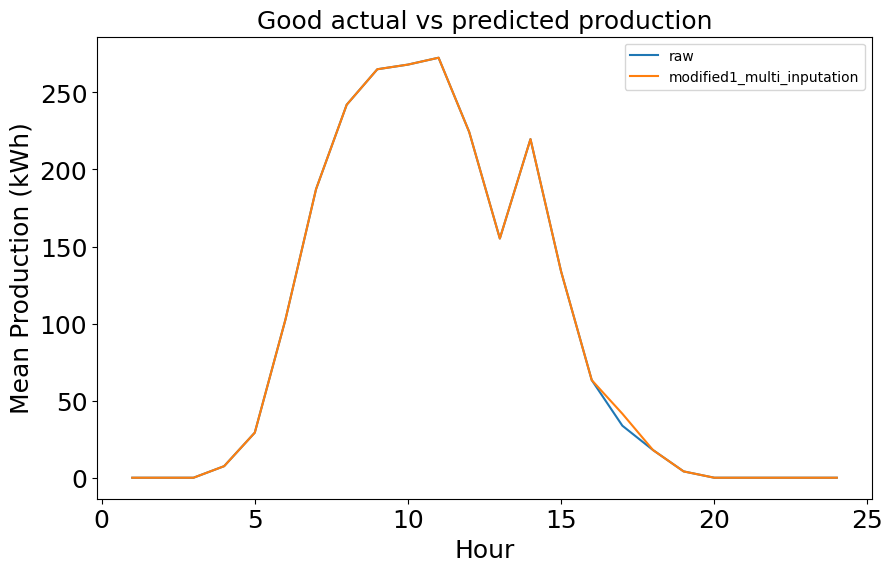

In [57]:
# lets check good fit with small MSE errors
row_index = mse_errors(df,'raw','modified1_multi_inputation').sort_values().head(50).index[49]
anomaly_date = anomaly_date = df[df.index == row_index]['date'].to_frame().reset_index(drop=True).loc[0,'date']

df[df['date'] == anomaly_date].plot('step',['raw','modified1_multi_inputation'],figsize=(10,6))

plt.xlabel('Hour',fontsize=18)
plt.ylabel('Mean Production (kWh)',fontsize=18)
plt.title('Good actual vs predicted production',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(loc='upper right')
plt.show()

So, in general our imputation models are not very bad.
Basically we haven't use any features at all (except sequential nature of the data) and maanged to come up with significantly OK result.

IV Data exploration and Feature engineering
    A. Data exploration
        a. Statistical insights of column raw
        b. Visuals to get insights
    B. Feature engineering
        a. Tranformation of the data

In [58]:
df = df[['timestamp','datetime','date','step','raw','temperature']]
df.head(3)

timestamp            datetime        date  step  raw  temperature
0  1612224000 2021-02-02 00:00:00  2021-02-02     1  0.0         -3.9
1  1612227600 2021-02-02 01:00:00  2021-02-02     2  0.0         -3.5
2  1612231200 2021-02-02 02:00:00  2021-02-02     3  0.0         -3.0

In [59]:
# I shall introduce additional hour column to perform analysis
df['hour'] = df['datetime'].dt.hour
df.head(3)

timestamp            datetime        date  step  raw  temperature  hour
0  1612224000 2021-02-02 00:00:00  2021-02-02     1  0.0         -3.9     0
1  1612227600 2021-02-02 01:00:00  2021-02-02     2  0.0         -3.5     1
2  1612231200 2021-02-02 02:00:00  2021-02-02     3  0.0         -3.0     2

A. Data exploration
    a. Statistical insights of column raw
    b. Visuals to get insights

In [60]:
df['raw'].describe(), df['raw'].quantile(0.9)

(count    17016.000000
 mean        36.912095
 std         66.907410
 min          0.000000
 25%          0.000000
 50%          0.000000
 75%         38.258015
 max        301.630010
 Name: raw, dtype: float64,
 154.98941)

From statistical description we can see that standard deviation is almost twice as high as mean. It indicates on large variability in the data such as high spread, possible outliers or skewness. If we look further, we can also notice that median is zero. It means that at least 50% of datapoints are equal to zero. So, data is having right-skewed distribution. Maximum value is almost 8 times larger and 90% quantile almost 5 times than mean. Thus, there is a spread in the data.
Let's check on distribution

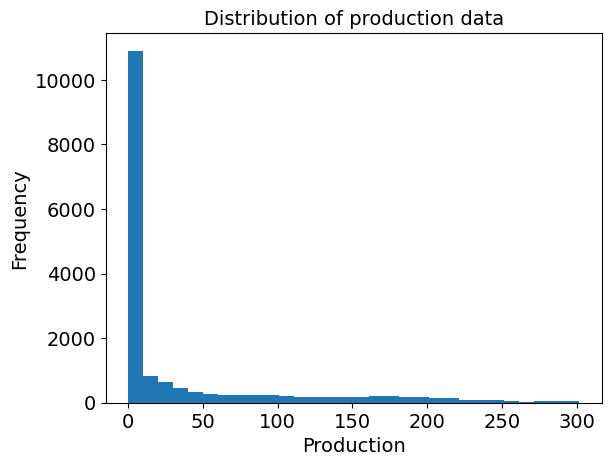

In [61]:
df['raw'].plot.hist(bins=30)

plt.xlabel('Production',fontsize=14)
plt.ylabel('Frequency',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Distribution of production data',fontsize=14)
plt.show()

Indeed, graphical representation of raw column, confirms what we stated above describing statistical insights of the data.
Lets get couple more nice charts to understand our data better.

I will plot:
    a. daily production of our PV (raw column)
    b. daily-hourly heat-map of PV production to better understand dependencies of production with respect to date and hour
    c. hourly box-plot to better understand statistics behind hourly production of PV (raw column)

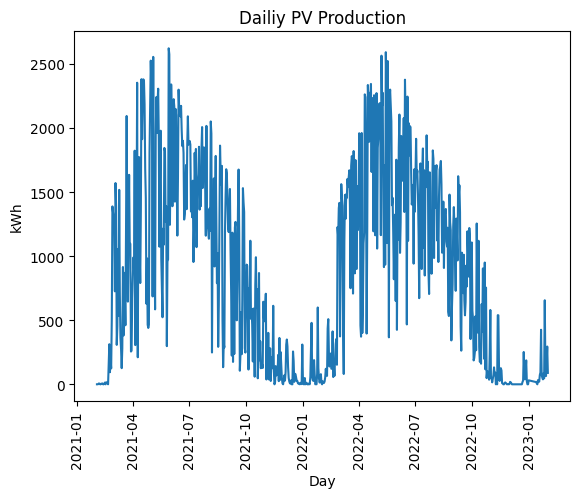

In [62]:
# Daily production of PV
df.groupby('date')['raw'].sum().plot()

plt.title("Dailiy PV Production")
plt.xlabel("Day")
plt.ylabel("kWh")
plt.xticks(rotation=90)
plt.show()

We can see that there is strong seasonal component in our data. 
For certain months production is significantly largr than for the others.
And this makes sence, as in summer there is so much more sun.
Now lets check hourly and daily-hourly insights

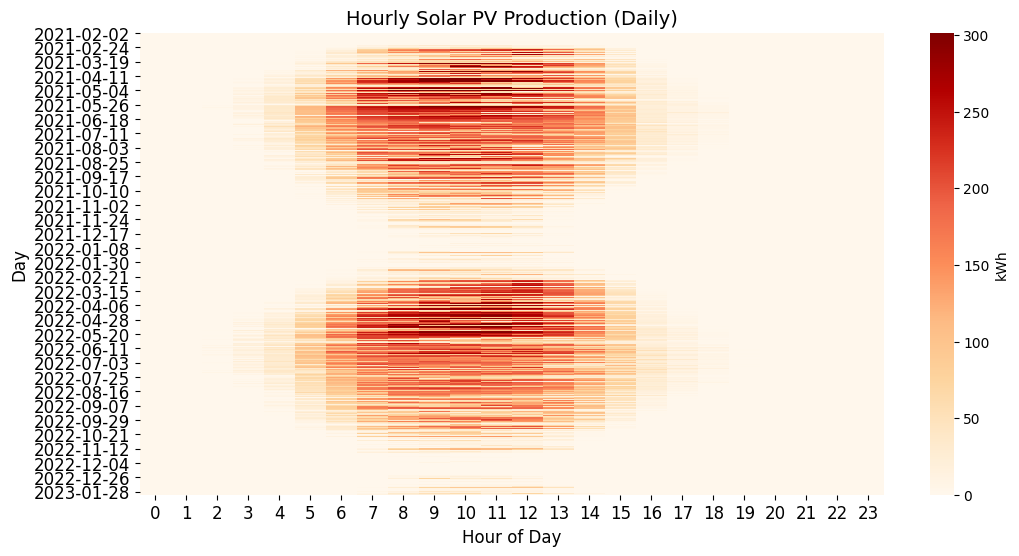

In [63]:
# Heat-map daily-hourly
hourly_avg = df.groupby('hour')['raw'].mean()
hourly_avg_df = df.pivot_table(values='raw', index=df['date'], columns=df['hour'])

plt.figure(figsize=(12, 6))
sns.heatmap(hourly_avg_df, cmap="OrRd", cbar_kws={'label': 'kWh'})
plt.title("Hourly Solar PV Production (Daily)",fontsize=14)
plt.xlabel("Hour of Day",fontsize=12)
plt.ylabel("Day",fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Heat-map basically concludes what we said above and we also can see hourly production dependency 

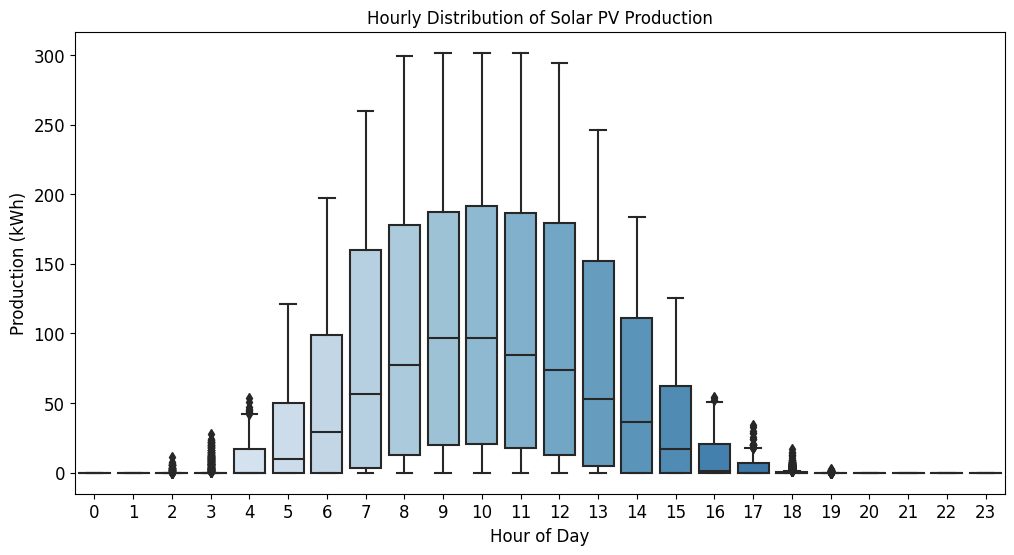

In [64]:
# Box plot hourly
df['hour'] = df['datetime'].dt.hour

plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='hour', y='raw', palette="Blues")
plt.title("Hourly Distribution of Solar PV Production",fontsize=12)
plt.xlabel("Hour of Day",fontsize=12)
plt.ylabel("Production (kWh)",fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


From box plot we can see hourly quatiles, spread, outliers. Basically box-plot also concludes our above findings

B. Feature engineering
    a. Tranformation of the data

Now, because data includes so many zeros it is extremly right-skewed. 
It is very hard to apply some kind of transformation to get normal distribution and not loose data (be able to perform back-transform)
But we also know, that zero occur during specific hour and these hours vary from month to month.
Lets use our data to create a month-hour map with zeros (basically night hours), mrge it with our dataframe and filter out night-hours

In [65]:
df['month'] = df['datetime'].dt.month

df_month_hour_production = df.groupby(['month','hour'])['raw'].sum().reset_index()
df_month_hour_production.loc[df_month_hour_production['raw'] == 0, 'sunny'] = 0
df_month_hour_production['sunny'] = df_month_hour_production['sunny'].fillna(1)
df_month_hour_production = df_month_hour_production.rename(columns={'raw':'sunny_production'})
df_month_hour_production = df_month_hour_production[['month','hour','sunny']]
df_month_hour_production.head(3)

month  hour  sunny
0      1     0    0.0
1      1     1    0.0
2      1     2    0.0

In [66]:
df = df.merge(df_month_hour_production,on=['month','hour'],how='inner')
df.head(3)

timestamp   datetime        date  step  raw  temperature  hour  month  \
0  1612224000 2021-02-02  2021-02-02     1  0.0         -3.9     0      2   
1  1612310400 2021-02-03  2021-02-03     1  0.0          2.1     0      2   
2  1612396800 2021-02-04  2021-02-04     1  0.0         -0.3     0      2   

   sunny  
0    0.0  
1    0.0  
2    0.0

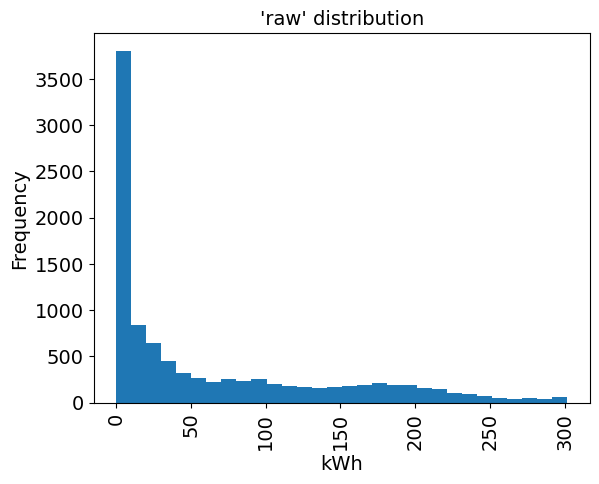

In [67]:
df_notnull = df[df['sunny'] > 0].reset_index()
df_notnull['raw'].plot.hist(bins=30)

plt.title("'raw' distribution",fontsize=14)
plt.xlabel("kWh",fontsize=14)
plt.ylabel("Frequency",fontsize=14)
plt.xticks(rotation=90,fontsize=14)
plt.yticks(fontsize=14)
plt.show()

It is better now, however still many zeros.
Zeros had such a big influence on transforming the data that I couldn't end up with nice transformation keeping so many zeros in the data
So in temrns of school project I dropped zeros and have done transofrmation of the data with out zeros

In [68]:
df_notnull = df_notnull[df_notnull['raw'] > 0].reset_index(drop=True)
df_notnull.head(3)

index   timestamp            datetime        date  step      raw  \
0    306  1614488400 2021-02-28 05:00:00  2021-02-28     6  0.85616   
1    332  1645851600 2022-02-26 05:00:00  2022-02-26     6  0.17410   
2    333  1645938000 2022-02-27 05:00:00  2022-02-27     6  1.81783   

   temperature  hour  month  sunny  
0          1.5     5      2    1.0  
1         -3.4     5      2    1.0  
2        -10.0     5      2    1.0

In [69]:
def root_transform(s,power):
    
    return np.power(s,power)

In [70]:
def root_back_transform(s,power):
    
    return np.power(s,power)

In [71]:
def log_e_transform(s):
    
    return np.log(s)

In [72]:
def log_e_backtransform(s):
    
    return np.exp(s)

And now lets apply some transformation and do reverse transformation to make sure data is not lsot

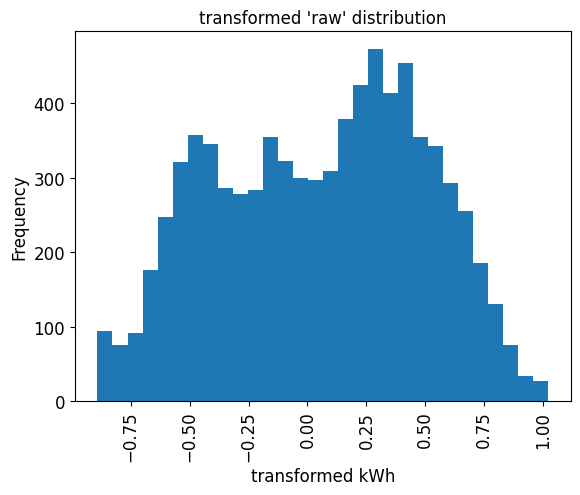

In [73]:
# Transformation

transformed = root_transform(df_notnull['raw'], 1/3)
transformed = root_transform(transformed,1/2)
transformed = log_e_transform(3 - transformed)

transformed.plot.hist(bins=30)

plt.title("transformed 'raw' distribution",fontsize=12)
plt.xlabel("transformed kWh",fontsize=12)
plt.ylabel("Frequency",fontsize=12)
plt.xticks(rotation=90,fontsize=12)
plt.yticks(fontsize=12)

plt.show()

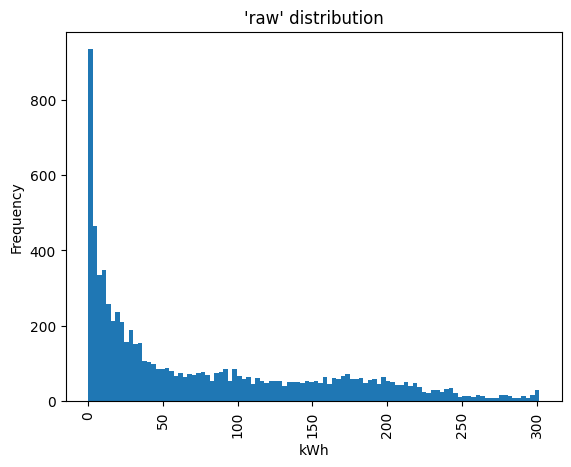

In [74]:
# Back transformation

back_transformed = 3 - log_e_backtransform(transformed)
back_transformed = root_back_transform(back_transformed,2)
back_transformed = root_back_transform(back_transformed, 3)

back_transformed.plot.hist(bins=100)

plt.title("'raw' distribution")
plt.xlabel("kWh")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.show()

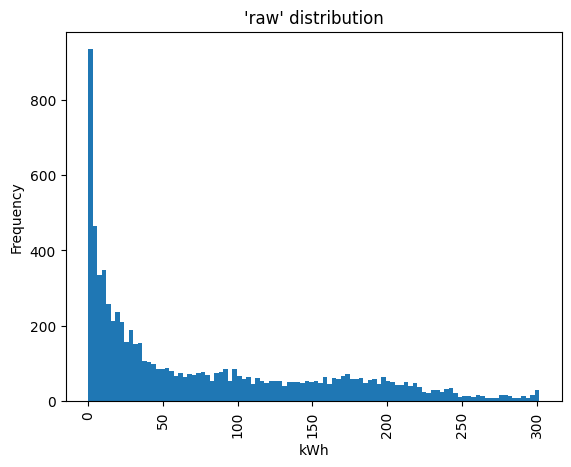

In [75]:
# Origina distribution
df_notnull['raw'].plot.hist(bins=100)

plt.title("'raw' distribution")
plt.xlabel("kWh")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.show()

After appling tansformation, distribution gets close to normal.
It is also nice that back-transformation could be applied without loosing any data
With that I colnclude section IV of analysis.

V.  Additive classical decomposition and typical generation profiles

In [76]:
# Lets keep needed columns
df = df[['timestamp','datetime','date','step','raw','temperature','hour','month']]
df.head(3)

timestamp   datetime        date  step  raw  temperature  hour  month
0  1612224000 2021-02-02  2021-02-02     1  0.0         -3.9     0      2
1  1612310400 2021-02-03  2021-02-03     1  0.0          2.1     0      2
2  1612396800 2021-02-04  2021-02-04     1  0.0         -0.3     0      2

Lets start with trend. We already saw above that months include seasonality.
That also means thta quarters will also include strong seasonal component.
Thus, the only logical way to get a trend would be to check trend yearly.
However we have only 2 years data which makes it rather not trend but some linear interpretation of a trend

Trend. As years are shifted, lets create quasi-years to check the trend

In [77]:
quasi_year_timedelta = pd.to_datetime(df['date']).min() - pd.to_datetime('2021-01-01')

df['quasi_date'] = df['date'] - quasi_year_timedelta
df['quasi_year'] = df['quasi_date'].astype('datetime64[ns]').dt.year

df.head(3)

timestamp   datetime        date  step  raw  temperature  hour  month  \
0  1612224000 2021-02-02  2021-02-02     1  0.0         -3.9     0      2   
1  1612310400 2021-02-03  2021-02-03     1  0.0          2.1     0      2   
2  1612396800 2021-02-04  2021-02-04     1  0.0         -0.3     0      2   

   quasi_date  quasi_year  
0  2021-01-01        2021  
1  2021-01-02        2021  
2  2021-01-03        2021

And check linear interpretation of a trend

In [78]:
df.groupby('quasi_year')['raw'].sum() - df.groupby('quasi_year')['raw'].sum().min()

quasi_year
2021        0.00000
2022    25586.91089
Name: raw, dtype: float64

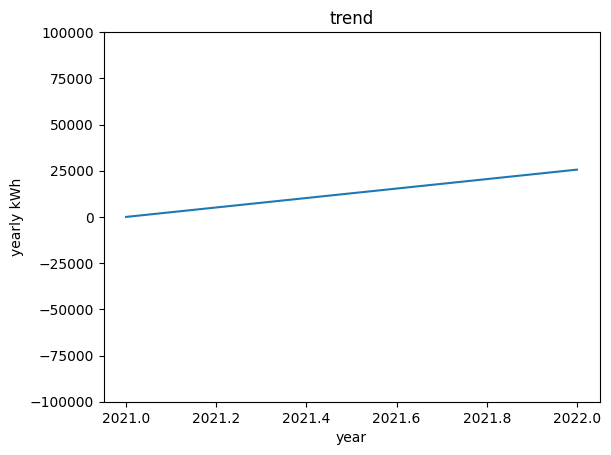

In [79]:
(df.groupby('quasi_year')['raw'].sum() - df.groupby('quasi_year')['raw'].sum().min()).plot()

plt.title("trend")
plt.xlabel("year")
plt.ylabel("yearly kWh")
plt.ylim(-100000,100000)
plt.xticks()
plt.show()

In [80]:
# Now lets create year-month object
df['year'] = df['datetime'].astype('datetime64[ns]').dt.year
df['month'] = df['datetime'].astype('datetime64[ns]').dt.month
df['year_month'] = df['year'].astype('str') + df['month'].astype('str').str.zfill(2)
df.head(3)

timestamp   datetime        date  step  raw  temperature  hour  month  \
0  1612224000 2021-02-02  2021-02-02     1  0.0         -3.9     0      2   
1  1612310400 2021-02-03  2021-02-03     1  0.0          2.1     0      2   
2  1612396800 2021-02-04  2021-02-04     1  0.0         -0.3     0      2   

   quasi_date  quasi_year  year year_month  
0  2021-01-01        2021  2021     202102  
1  2021-01-02        2021  2021     202102  
2  2021-01-03        2021  2021     202102

Now lets check what are the monthly productions

Now we have a choice. To trust the 'trend' based on 2 datapoints or neglect it.
If we compare trend to monthly productions we can see that trend component would be larger than half of months productions that we have.
In terms of this school assingment I will ignore or neglect trend, basically setting T(t) = 0 as it is not seems to be good idea to calculate trend on 2 datapoints


Next lets derive seasonality. 
We will calculate seasonality based on mean monthly production

In [81]:
monthly_production = df.groupby(['year','month'])['raw'].sum().reset_index()#.rename(columns={'raw':'mean_monthly_production'})
monthly_production['year_month'] = monthly_production['year'].astype('str') + monthly_production['month'].astype('str').str.zfill(2)
monthly_production.head(3)

year  month          raw year_month
0  2021      2   4227.22569     202102
1  2021      3  25155.05614     202103
2  2021      4  41574.29456     202104

In [82]:
mean_monthly_production = monthly_production.groupby('month')['raw'].mean().reset_index().rename(columns={'raw':'raw_mean'})
mean_monthly_production.head(3)

month      raw_mean
0      1   2314.894200
1      2   4060.010767
2      3  32240.962395

In [83]:
monthly_production = monthly_production.merge(mean_monthly_production,on='month')
monthly_production.head(3)

year  month         raw year_month     raw_mean
0  2021      2  4227.22569     202102  4060.010767
1  2022      2  7863.75500     202202  4060.010767
2  2023      2    89.05161     202302  4060.010767

In [84]:
monthly_production = monthly_production.sort_values(by=['year','month'])
monthly_production.head(3)

year  month          raw year_month      raw_mean
0  2021      2   4227.22569     202102   4060.010767
3  2021      3  25155.05614     202103  32240.962395
5  2021      4  41574.29456     202104  45522.081355

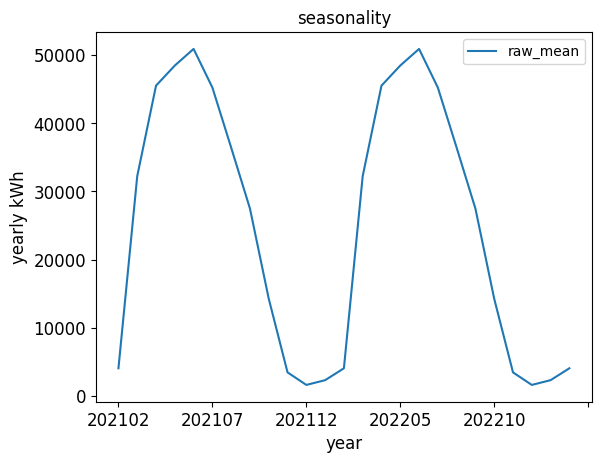

In [85]:
# Plotting seasonality
monthly_production.plot(x='year_month',y='raw_mean')

plt.title("seasonality",fontsize=12)
plt.xlabel("year",fontsize=12)
plt.ylabel("yearly kWh",fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

After deriving S(t) seasonal component and knowing that T(t) equals to zero we can calculate residial by subtracting seasonal component from raw

In [86]:
# Calculating residial
monthly_production['residial'] = monthly_production['raw'] - monthly_production['raw_mean']
monthly_production.head(3)

year  month          raw year_month      raw_mean     residial
0  2021      2   4227.22569     202102   4060.010767   167.214923
3  2021      3  25155.05614     202103  32240.962395 -7085.906255
5  2021      4  41574.29456     202104  45522.081355 -3947.786795

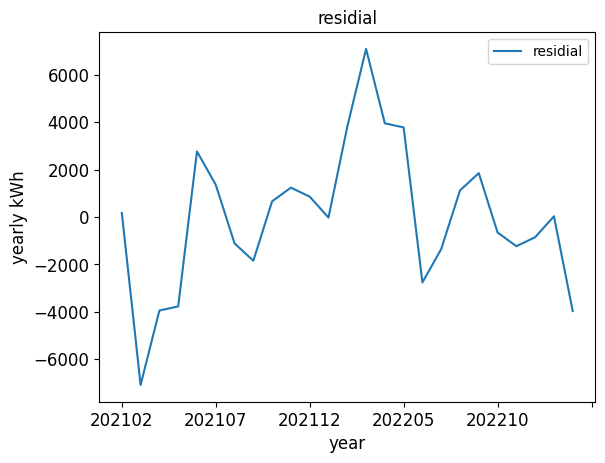

In [87]:
# Plotting residial
monthly_production.plot(x='year_month',y='residial')

plt.title("residial",fontsize=12)
plt.xlabel("year",fontsize=12)
plt.ylabel("yearly kWh",fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Now we must calculate components back and get curve containing all three components
T(t) + S(t) + R(t) = Original(t)

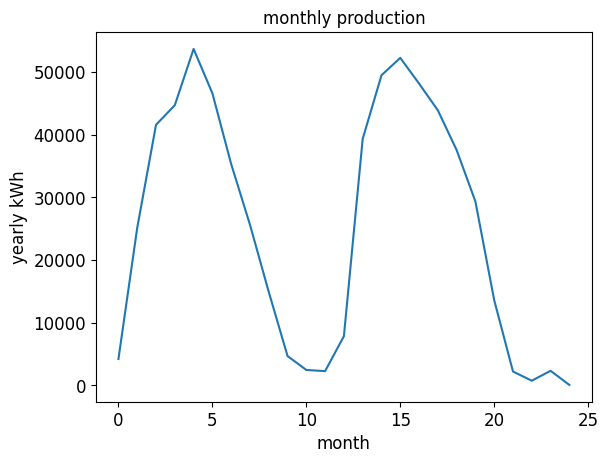

In [88]:
# Plotting original curve using back-engineering
(0 + monthly_production['raw_mean'] + monthly_production['residial']).reset_index(drop=True).plot()

plt.title("monthly production",fontsize=12)
plt.xlabel("month",fontsize=12)
plt.ylabel("yearly kWh",fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


And result is exactly what is expected.

Lets now check typical generation profiles.
We will make monthly based low and high production week-profiles

For that, first of all I shall create new variable day_of_week (as I want montly based weekly profiles)

In [89]:
df['day_of_week'] = df['datetime'].dt.dayofweek
df.head(3)

timestamp   datetime        date  step  raw  temperature  hour  month  \
0  1612224000 2021-02-02  2021-02-02     1  0.0         -3.9     0      2   
1  1612310400 2021-02-03  2021-02-03     1  0.0          2.1     0      2   
2  1612396800 2021-02-04  2021-02-04     1  0.0         -0.3     0      2   

   quasi_date  quasi_year  year year_month  day_of_week  
0  2021-01-01        2021  2021     202102            1  
1  2021-01-02        2021  2021     202102            2  
2  2021-01-03        2021  2021     202102            3

And week number variable, to keep all month weeks together

In [90]:
df['week_number'] = df['datetime'].dt.week
df.head(3)

timestamp   datetime        date  step  raw  temperature  hour  month  \
0  1612224000 2021-02-02  2021-02-02     1  0.0         -3.9     0      2   
1  1612310400 2021-02-03  2021-02-03     1  0.0          2.1     0      2   
2  1612396800 2021-02-04  2021-02-04     1  0.0         -0.3     0      2   

   quasi_date  quasi_year  year year_month  day_of_week  week_number  
0  2021-01-01        2021  2021     202102            1            5  
1  2021-01-02        2021  2021     202102            2            5  
2  2021-01-03        2021  2021     202102            3            5

Now, I will filter out only weeks which occupy whole month (weeks with cross-months I will drop in ordr to simplify HA as it is a school project)

In [91]:
df_count_of_days_in_week_per_year_month = (df.groupby(['year','month','week_number'])['day_of_week'].count() / 24).reset_index()
df_count_of_days_in_week_per_year_month.head(3)

year  month  week_number  day_of_week
0  2021      2            5          6.0
1  2021      2            6          7.0
2  2021      2            7          7.0

In [92]:
# Keep only clean weeks with no inter-month interaction
df_count_of_days_in_week_per_year_month_clean = df_count_of_days_in_week_per_year_month[df_count_of_days_in_week_per_year_month['day_of_week'] == 7].reset_index(drop=True)
df_count_of_days_in_week_per_year_month_clean.head(3)

year  month  week_number  day_of_week
0  2021      2            6          7.0
1  2021      2            7          7.0
2  2021      2            8          7.0

And filter-out 'pure' weeks which occupy only single month

In [93]:
# keep only data which includes whole-month weeks
df_whole_month_week = df.merge(df_count_of_days_in_week_per_year_month_clean[['year','month','week_number']],on=['year','month','week_number'],how='inner').reset_index(drop=True)
df_whole_month_week.head(3)

timestamp   datetime        date  step  raw  temperature  hour  month  \
0  1612742400 2021-02-08  2021-02-08     1  0.0         15.2     0      2   
1  1612828800 2021-02-09  2021-02-09     1  0.0          9.7     0      2   
2  1612915200 2021-02-10  2021-02-10     1  0.0          9.0     0      2   

   quasi_date  quasi_year  year year_month  day_of_week  week_number  
0  2021-01-07        2021  2021     202102            0            6  
1  2021-01-08        2021  2021     202102            1            6  
2  2021-01-09        2021  2021     202102            2            6

Create year_week variable to count all weeks of the month through-out whole year and sort dataframe

In [94]:
df_whole_month_week['year_week'] = df_whole_month_week['year'].astype(str) + df_whole_month_week['week_number'].astype(str).str.zfill(2)
df_whole_month_week.head(3)

timestamp   datetime        date  step  raw  temperature  hour  month  \
0  1612742400 2021-02-08  2021-02-08     1  0.0         15.2     0      2   
1  1612828800 2021-02-09  2021-02-09     1  0.0          9.7     0      2   
2  1612915200 2021-02-10  2021-02-10     1  0.0          9.0     0      2   

   quasi_date  quasi_year  year year_month  day_of_week  week_number year_week  
0  2021-01-07        2021  2021     202102            0            6    202106  
1  2021-01-08        2021  2021     202102            1            6    202106  
2  2021-01-09        2021  2021     202102            2            6    202106

In [95]:
df_whole_month_week = df_whole_month_week.sort_values(by=['timestamp']).reset_index(drop=True)
df_whole_month_week.head(3)

timestamp            datetime        date  step  raw  temperature  hour  \
0  1612742400 2021-02-08 00:00:00  2021-02-08     1  0.0         15.2     0   
1  1612746000 2021-02-08 01:00:00  2021-02-08     2  0.0         14.7     1   
2  1612749600 2021-02-08 02:00:00  2021-02-08     3  0.0         14.5     2   

   month  quasi_date  quasi_year  year year_month  day_of_week  week_number  \
0      2  2021-01-07        2021  2021     202102            0            6   
1      2  2021-01-07        2021  2021     202102            0            6   
2      2  2021-01-07        2021  2021     202102            0            6   

  year_week  
0    202106  
1    202106  
2    202106

Now, i will groupby year_week and cumcount each year_week. I shall get 168 hours weekly (sorted).
After that I can start modelling profiles

In [96]:
df_monthly_profile_data = pd.DataFrame(columns=['timestamp','month','year_week','week_number','hour','raw','ts'])

for month in df_whole_month_week['month'].unique():
        
    df_month_profiles = df_whole_month_week[df_whole_month_week['month'] == month].reset_index(drop=True)
    df_month_profiles['ts'] = df_month_profiles.groupby('year_week')['timestamp'].cumcount()
    
    df_month_profiles = df_month_profiles[['timestamp','month','year_week','week_number','hour','raw','ts']]
    
    df_monthly_profile_data = pd.concat([df_monthly_profile_data,df_month_profiles])

df_monthly_profile_data = df_monthly_profile_data.reset_index(drop=True)
df_monthly_profile_data

timestamp month year_week week_number hour  raw   ts
0      1612742400     2    202106           6    0  0.0    0
1      1612746000     2    202106           6    1  0.0    1
2      1612749600     2    202106           6    2  0.0    2
3      1612753200     2    202106           6    3  0.0    3
4      1612756800     2    202106           6    4  0.0    4
...           ...   ...       ...         ...  ...  ...  ...
13267  1675018800     1    202304           4   19  0.0  163
13268  1675022400     1    202304           4   20  0.0  164
13269  1675026000     1    202304           4   21  0.0  165
13270  1675029600     1    202304           4   22  0.0  166
13271  1675033200     1    202304           4   23  0.0  167

[13272 rows x 7 columns]

Finally, I will use simple k-means to cluster weeks of each month to get 2 clusters.
I shall get monthly: low-production weeks and high-production weeks
I'am using quite straight forward hourly k-means to do that and also I have only from six to eight week monthly.
Thus, result of clustering min and max monthly generation profiles might look strange
Methods like dynamic time warping or using much more data would probably help to make data more logical

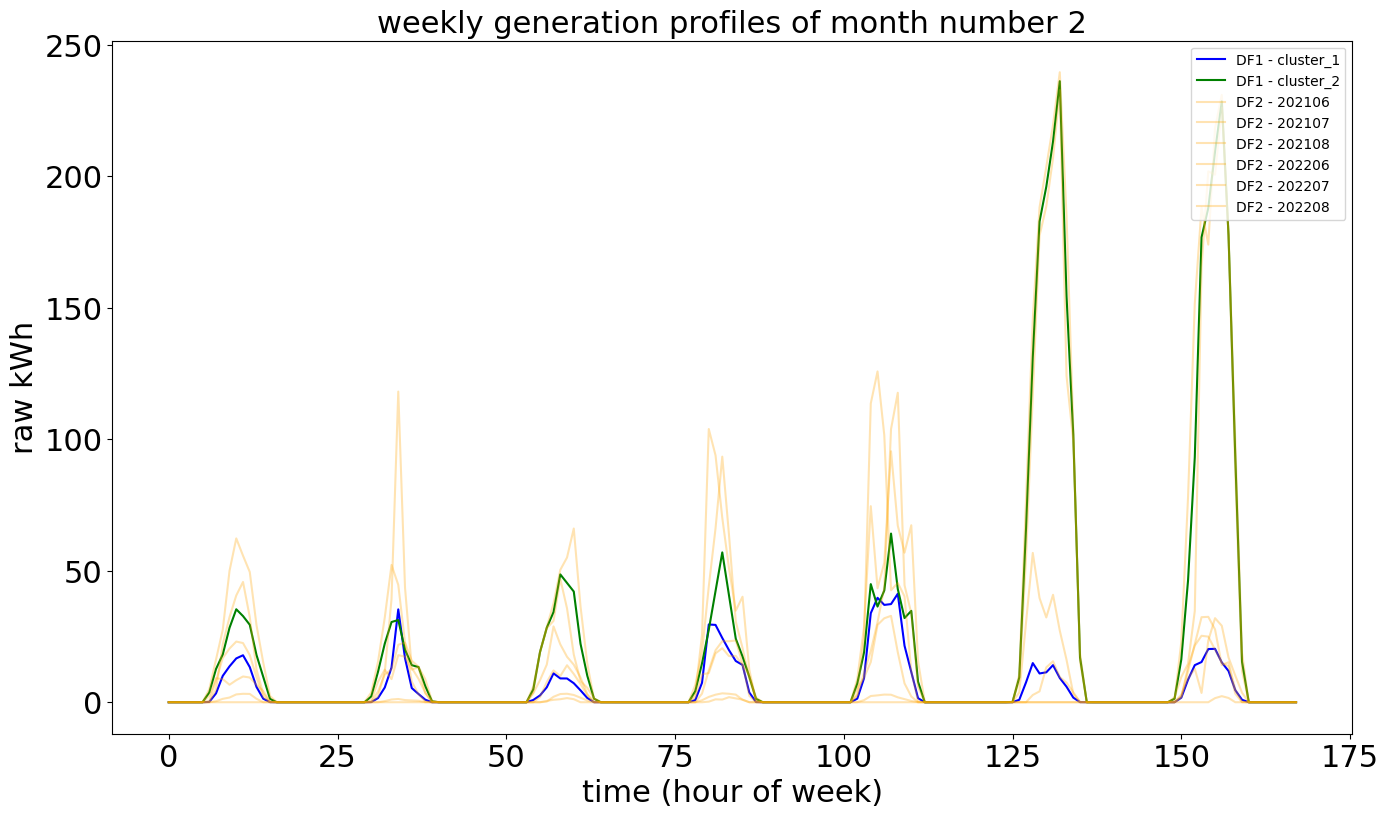

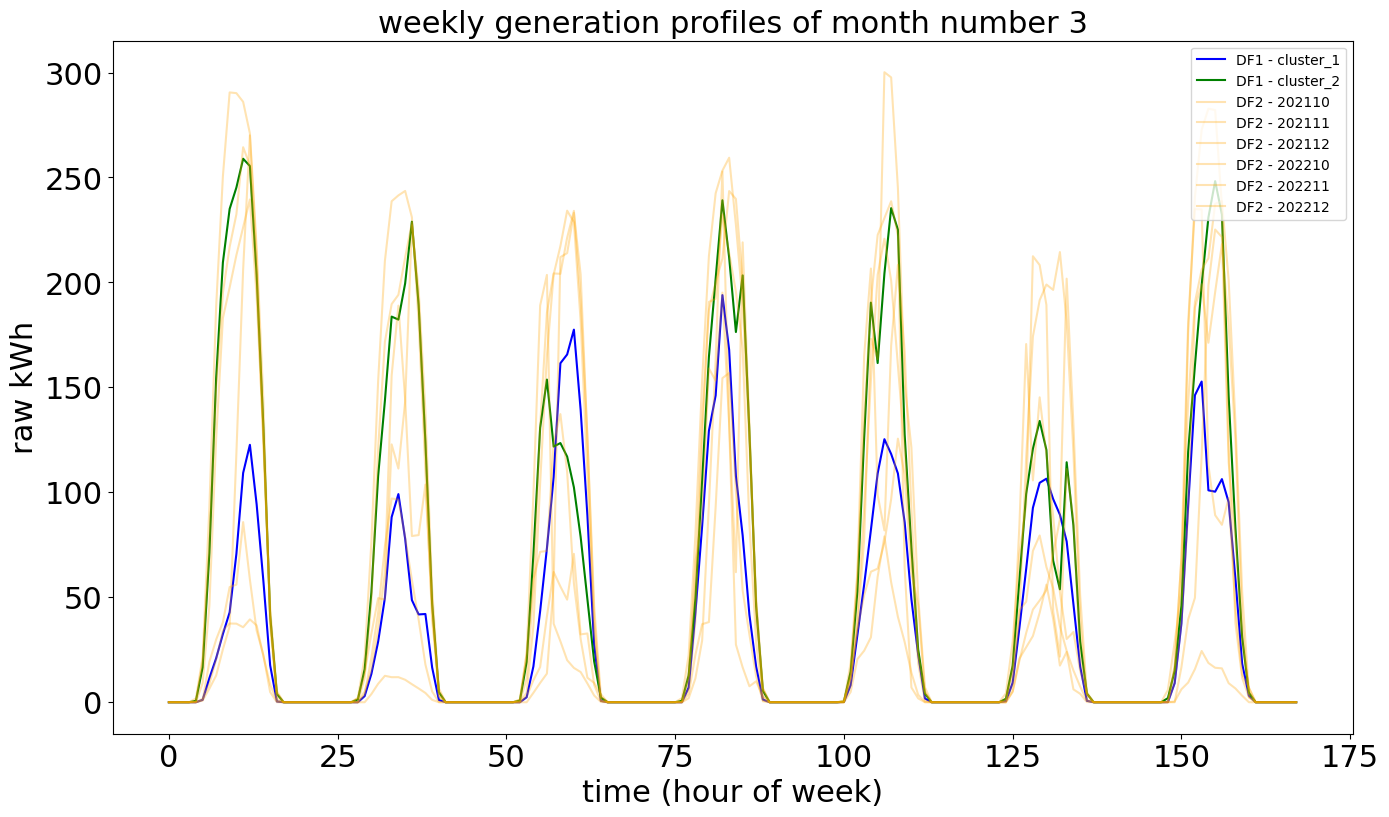

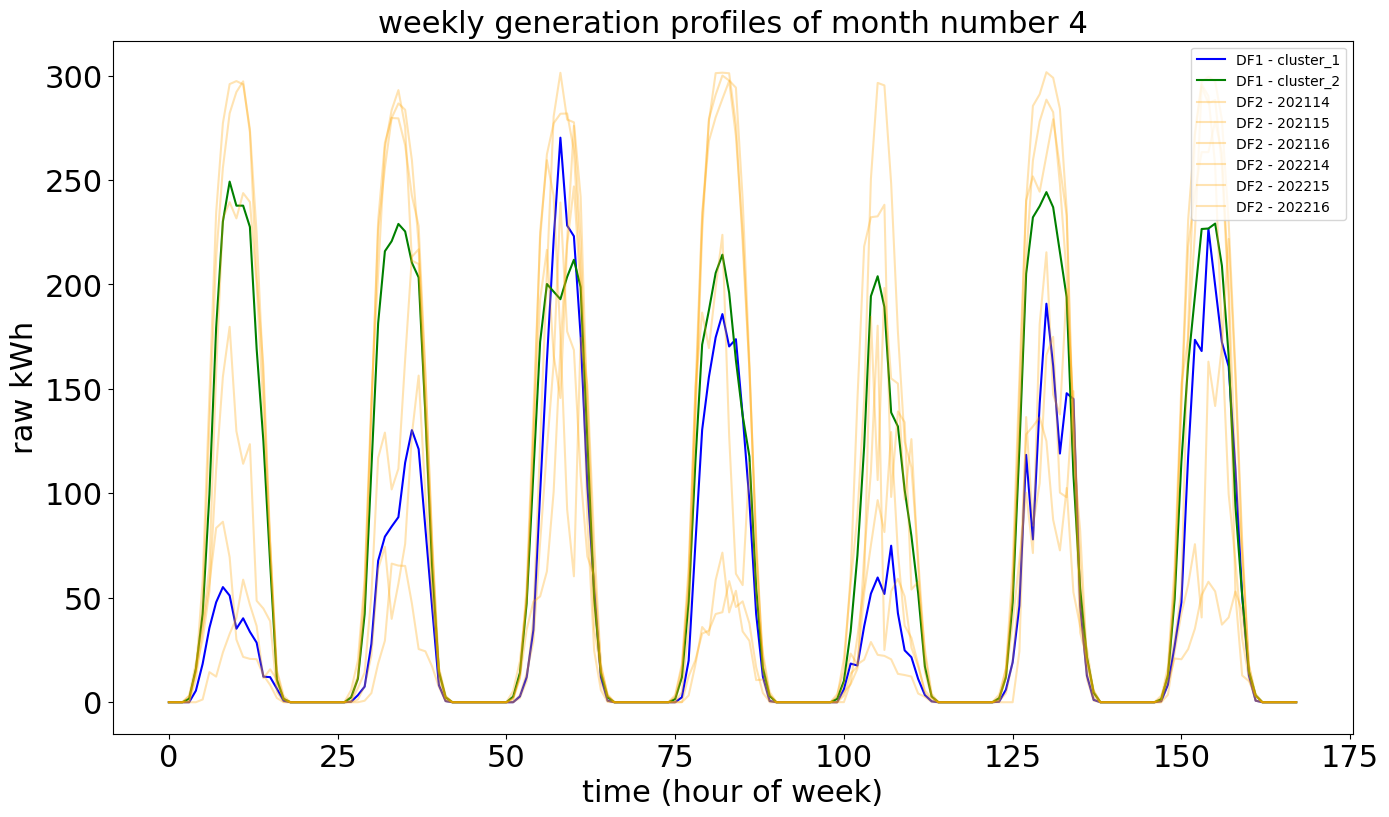

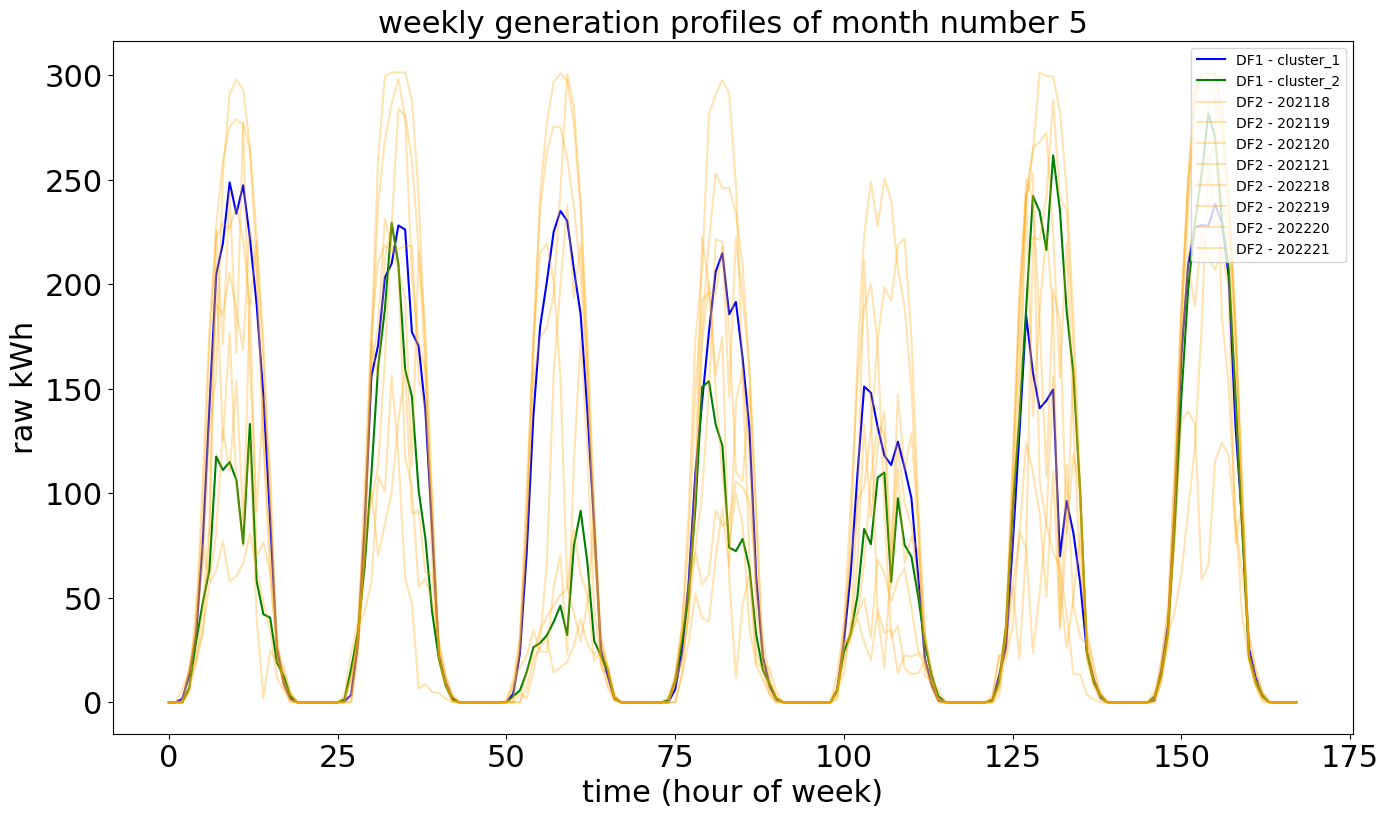

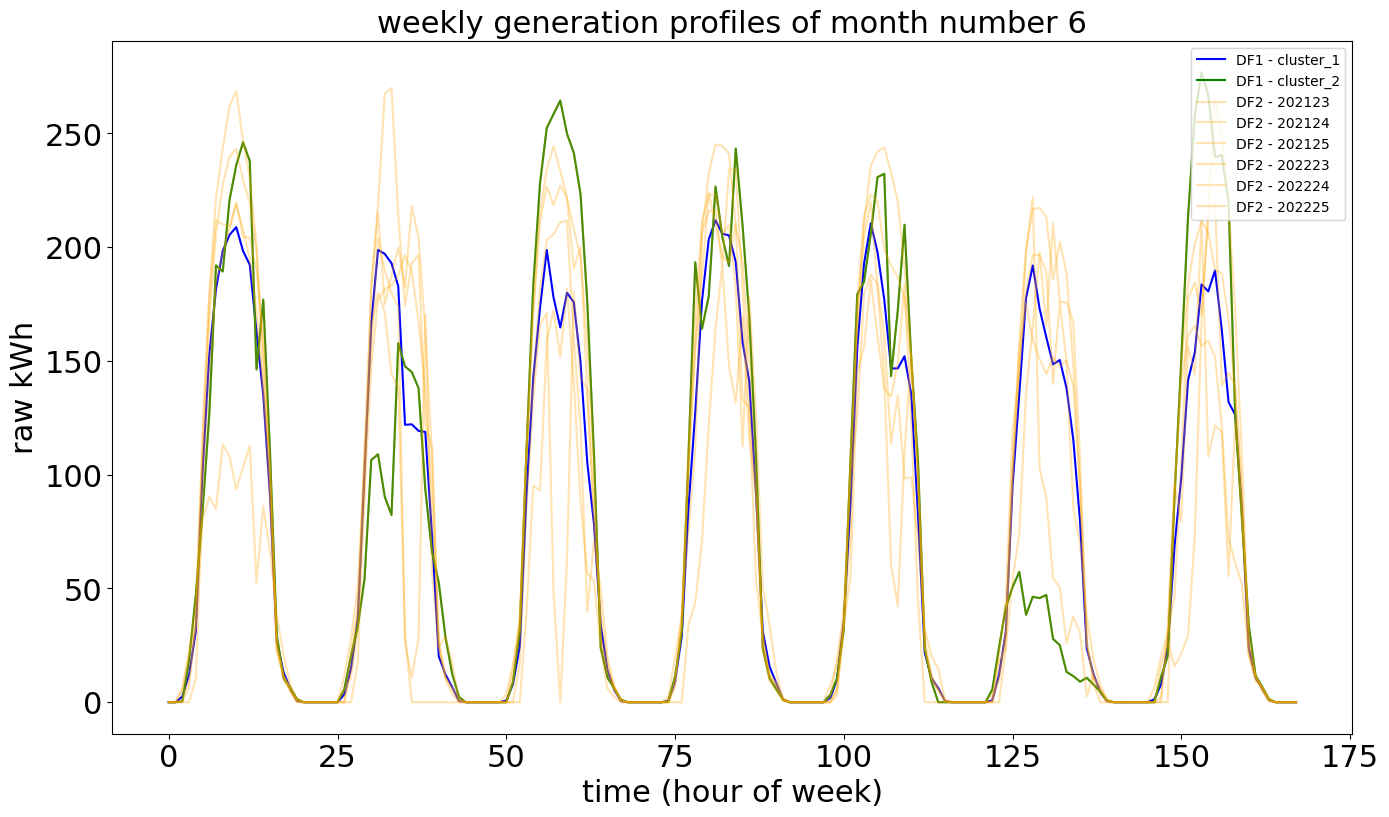

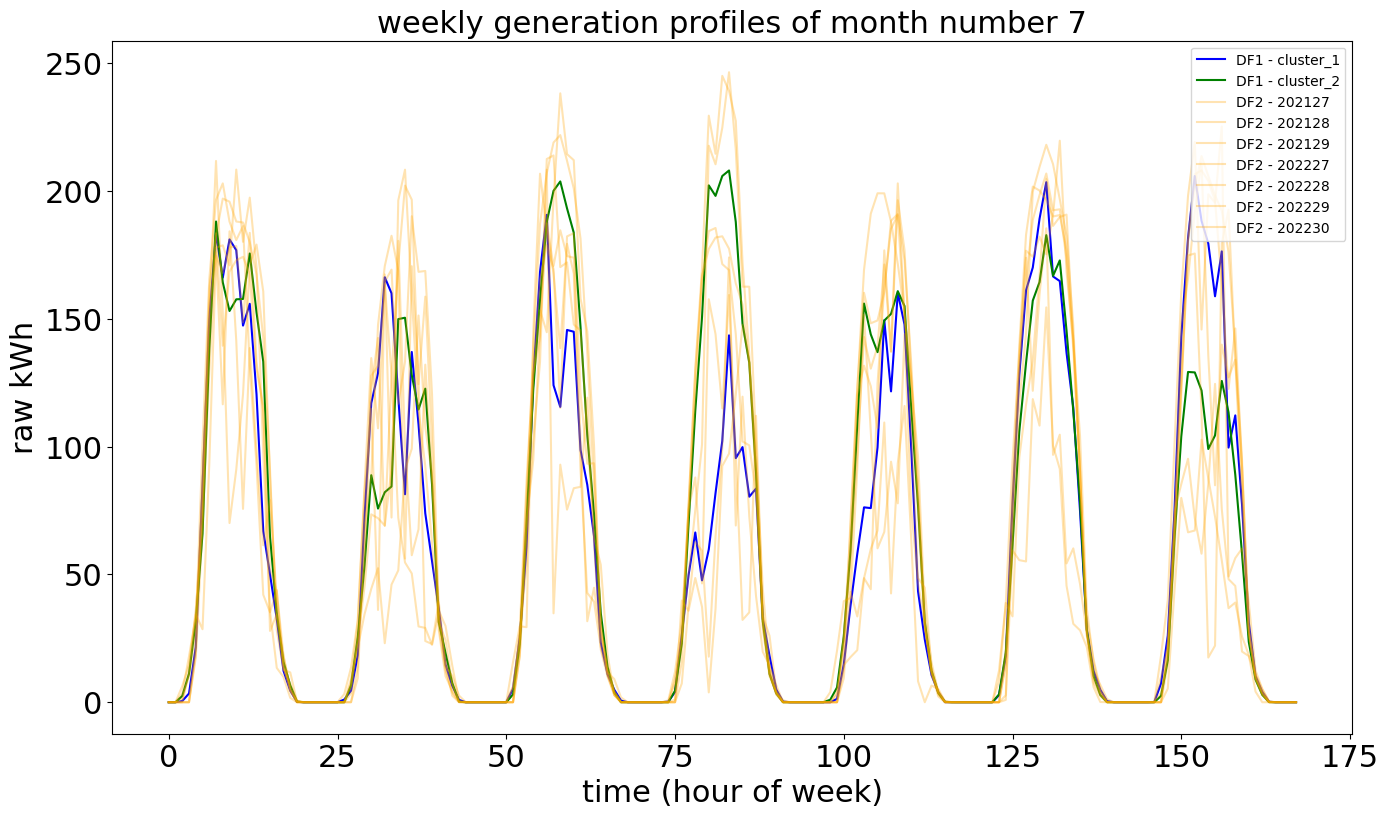

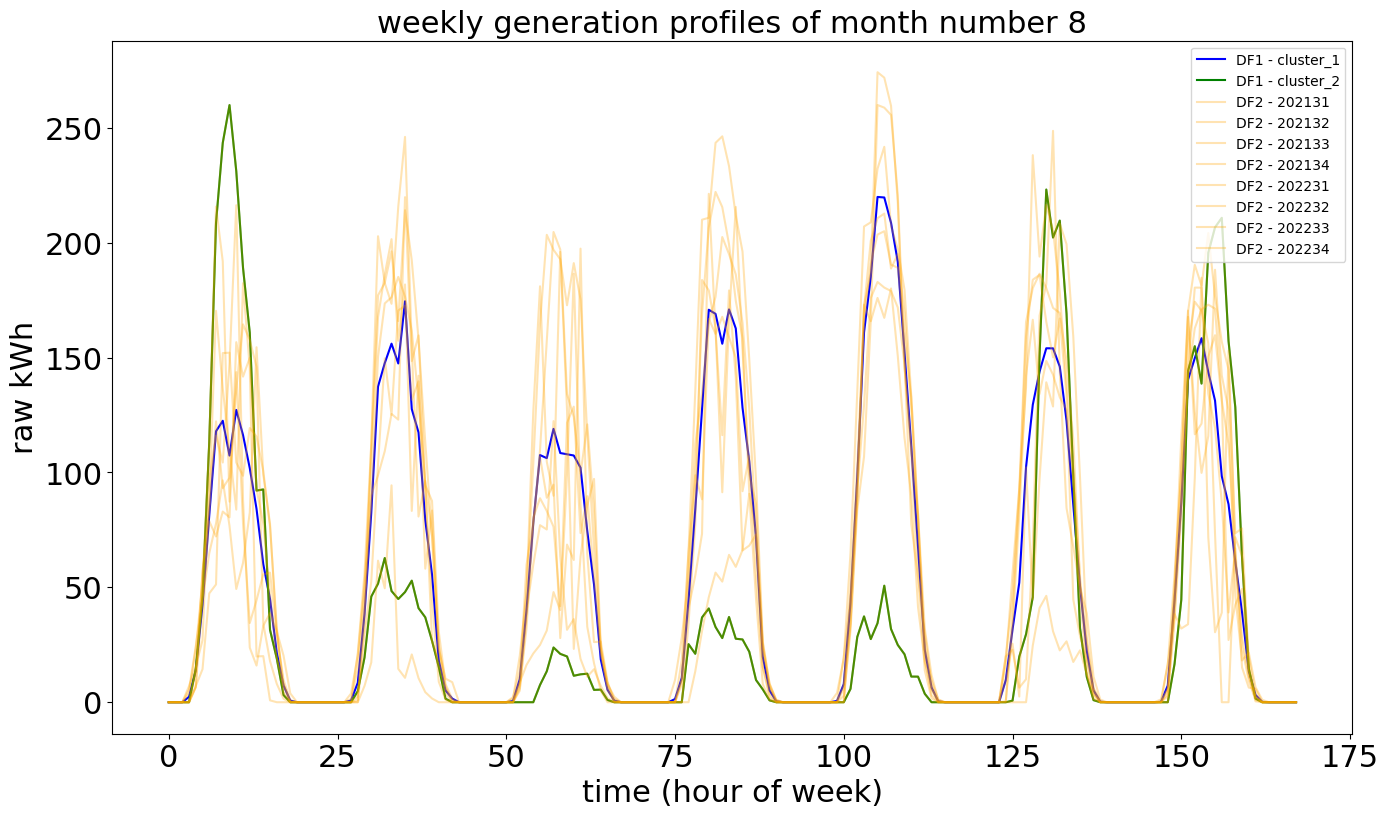

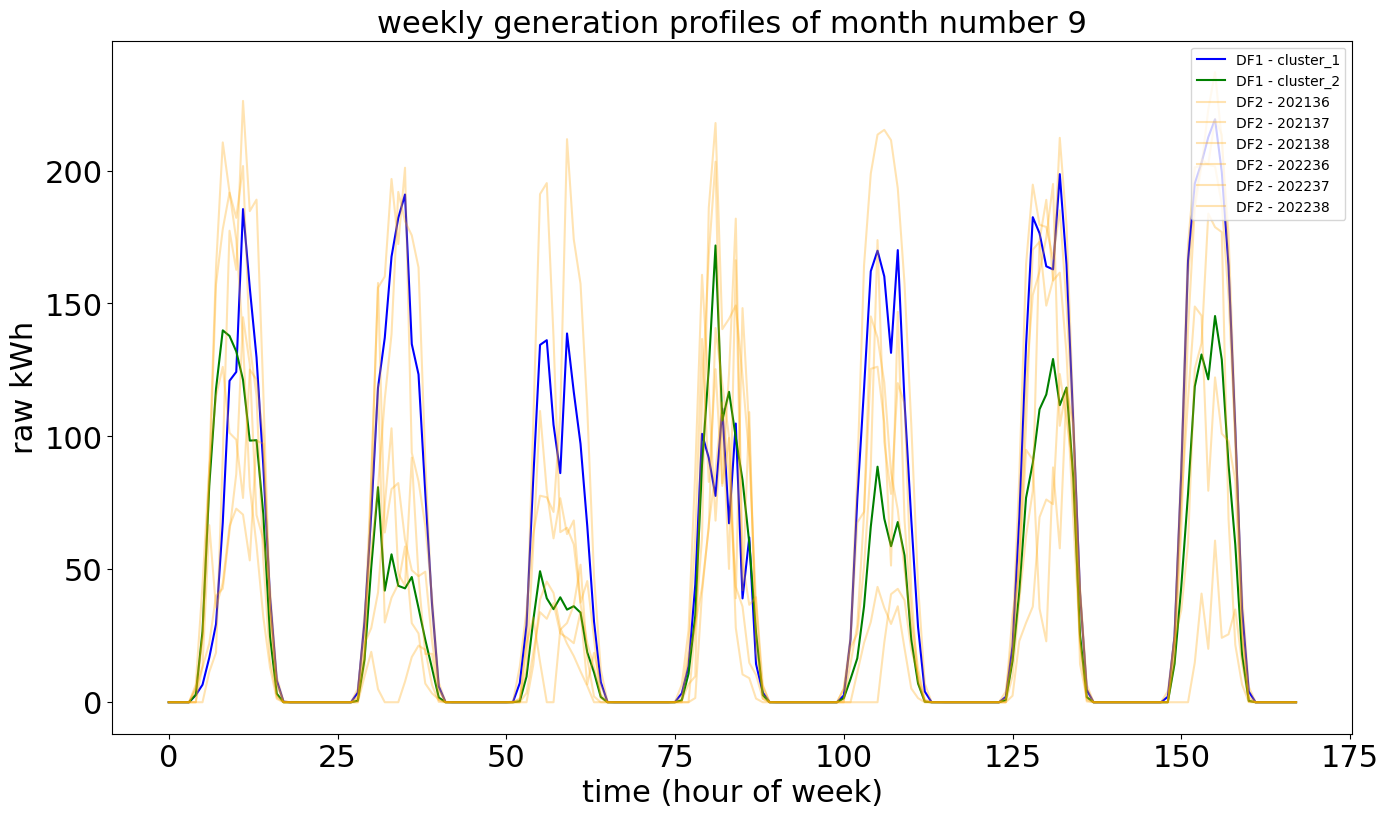

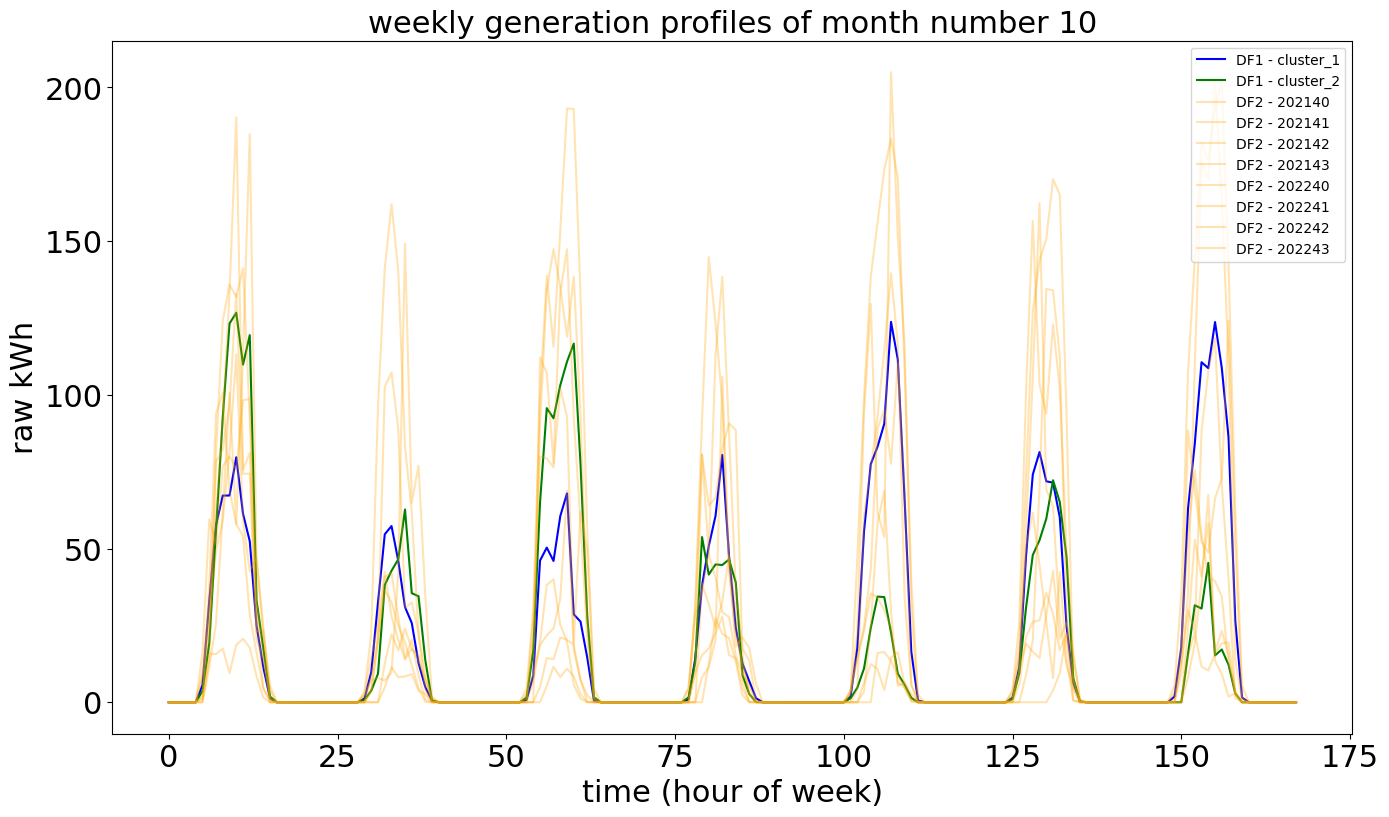

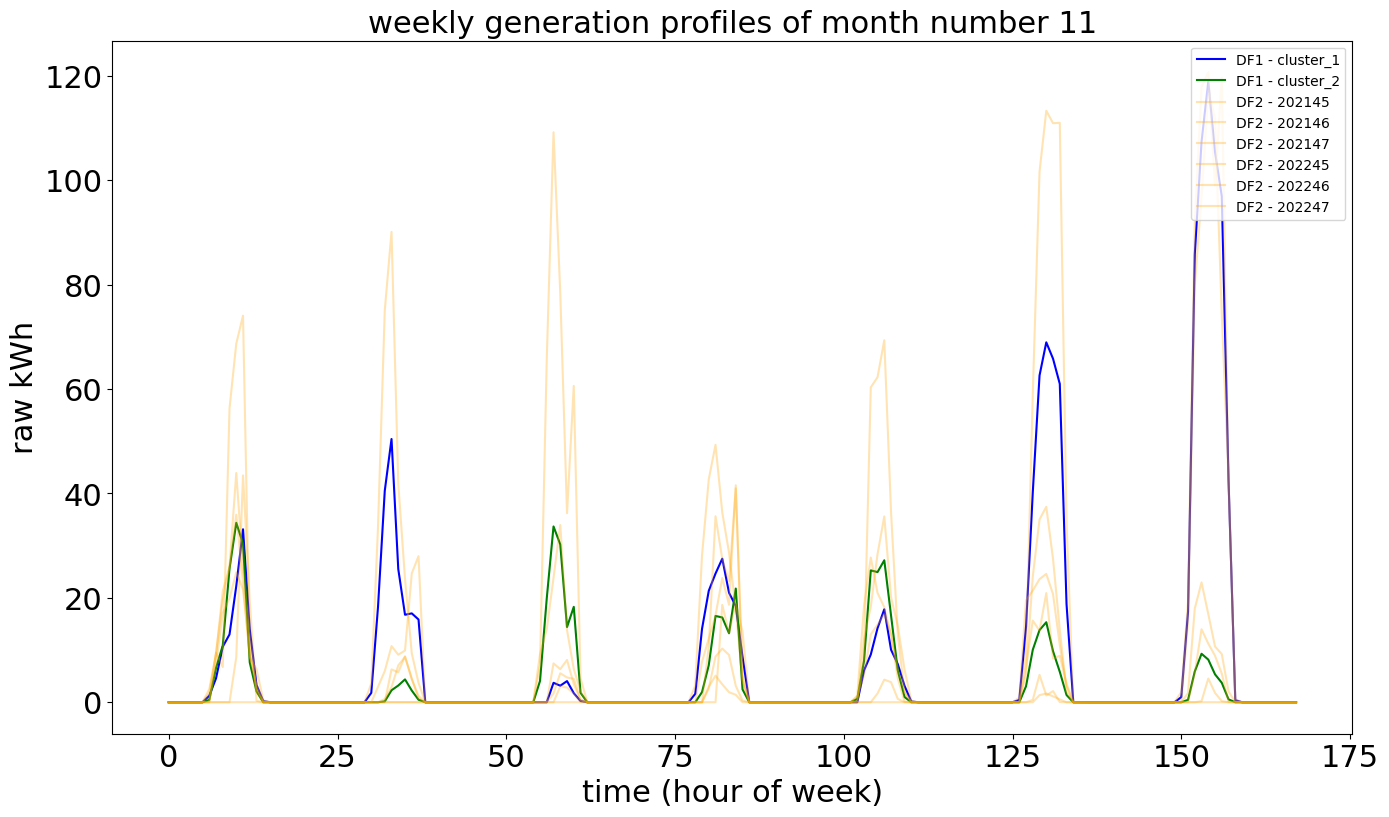

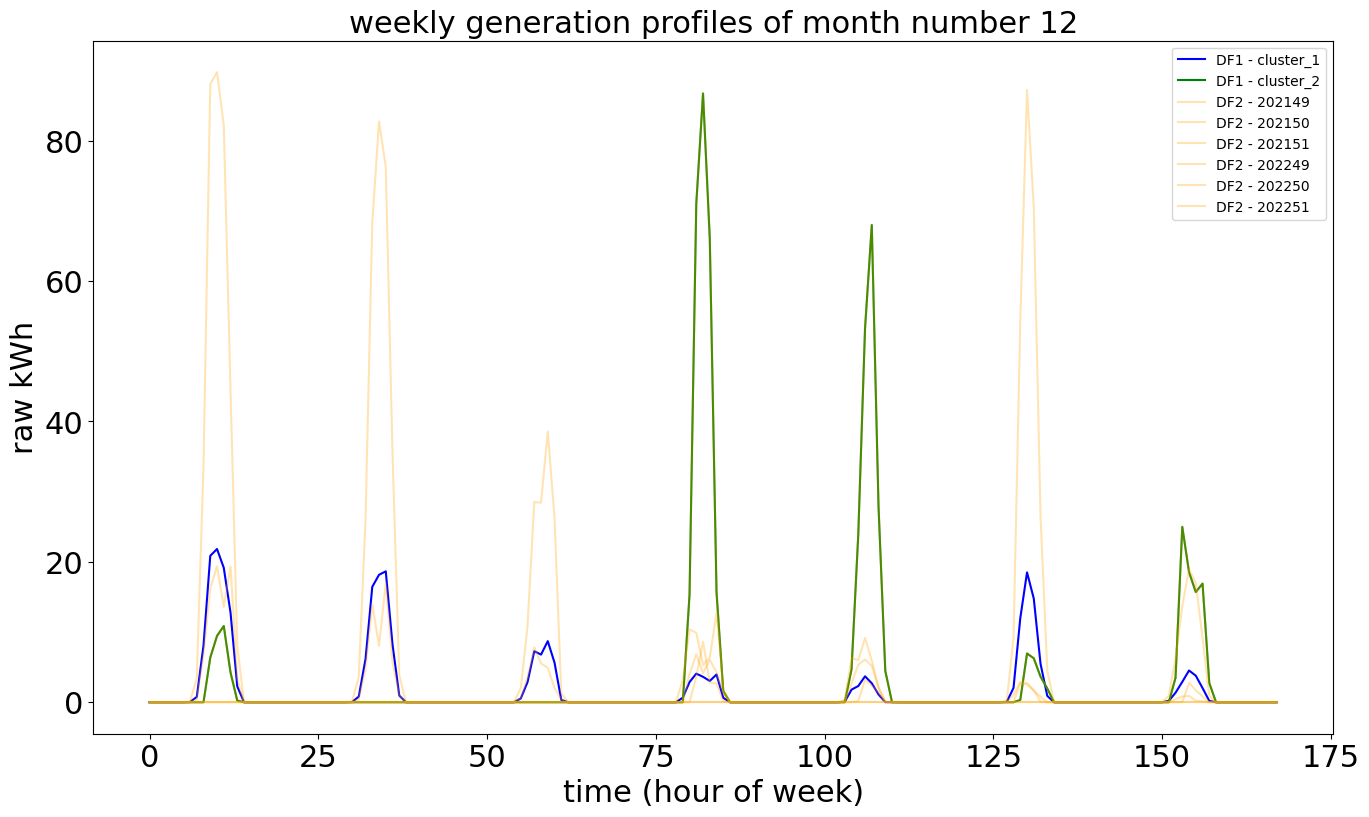

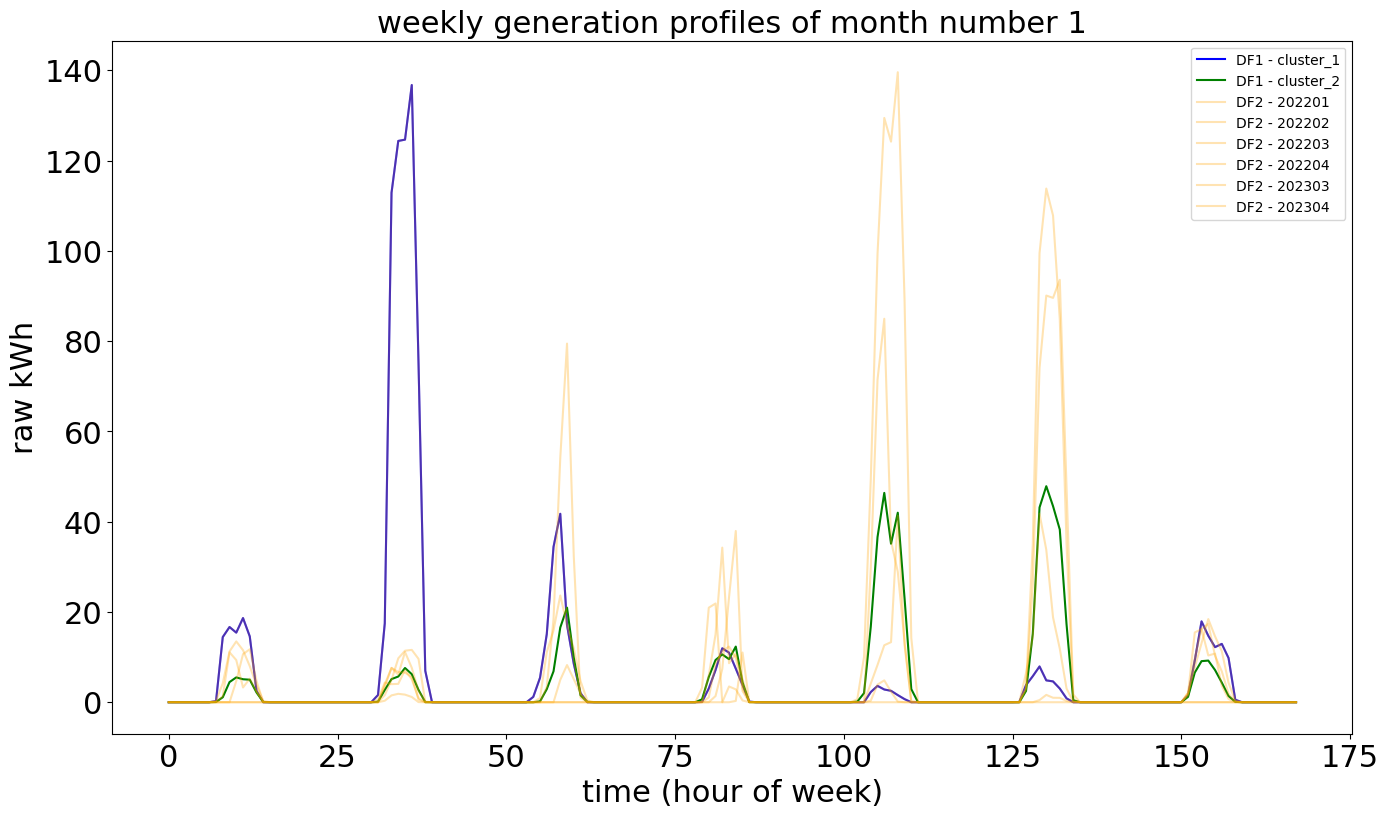

In [97]:
for month in df_monthly_profile_data['month'].unique():
    
    df_helper = df_monthly_profile_data[df_monthly_profile_data['month'] == month]
        
    weekly_data = df_helper.pivot(index='year_week', columns='ts', values='raw')
    weekly_data.columns = [f'hour_{i}' for i in range(168)]
    
    kmeans = KMeans(n_clusters=2, random_state=0)
    kmeans.fit_predict(weekly_data)
    
    min_max_weekly_profiles = kmeans.cluster_centers_
        
    df_clusters = pd.DataFrame(columns=['year_week','ts','raw'])
    
    df_cluster_1 = pd.DataFrame(min_max_weekly_profiles[0],columns=['raw'])
    df_cluster_1['ts'] = df_cluster_1.index
    df_cluster_1['year_week'] = 'cluster_1'
    
    df_cluster_2 = pd.DataFrame(min_max_weekly_profiles[1],columns=['raw'])
    df_cluster_2['ts'] = df_cluster_2.index
    df_cluster_2['year_week'] = 'cluster_2'
    
    df_clusters = pd.concat([df_cluster_1,df_cluster_2],axis=0).reset_index(drop=True)    
            
    plt.figure(figsize=(16, 9))
    
    colors = itertools.cycle(['blue', 'green', 'purple', 'red', 'cyan', 'magenta'])

    for cluster_name, group in df_clusters.groupby('year_week'):
        plt.plot(group['ts'], group['raw'], label=f'DF1 - {cluster_name}', color=next(colors), alpha=1)

    for year_week, group in df_helper.groupby('year_week'):
        plt.plot(group['ts'], group['raw'], label=f'DF2 - {year_week}', color='orange', alpha=0.3)

    plt.xlabel('time (hour of week)',fontsize=22)
    plt.ylabel('raw kWh',fontsize=22)
    plt.title('weekly generation profiles of month number ' + str(month),fontsize=22)
    plt.legend(loc='upper right')
    plt.xticks(fontsize=22)
    plt.yticks(fontsize=22)
    plt.show()


Now, we have our profiles and more or less can plan monthly, what would be week based hourly min and max PV production
With that, I finish this HA